# Removing Non-predictive features

From the EDA, it was analyzed and cleared about the features which have predictive power for churn.

The features like `gender`, `CustomerId`, `Phoneservice` was found to be non-predictive. Customer Id have unique lables with alphanumeric and it doesn't even have a predictive power for churn. The gender is likely balanced, actually there was no such trend for churn between male and female. The churn was not based on gender but other technical and financial factors. Phoneservice was highly imbalanced and biased. So taking it may mislead the modelling process.

Ignoring these features for splitting data because holding these less predictive features may led to data leakage

## Splitting the dataset

In [ ]:
import pandas as pd

In [ ]:
pd.set_option("display.max_columns", None)

customer_df = pd.read_csv("dataset\raw_dataset.csv")
customer_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
customer_df['Churn'].value_counts(normalize=True)

,proportion
Churn,
No,0.73463
Yes,0.26537


#### Dropping non-predictive features

In [ ]:
df = customer_df.copy()

In [ ]:
df = df.drop(columns=['customerID',	'gender', 'PhoneService'], axis=1)

In [ ]:
df['PaymentMethod'] = df['PaymentMethod'].replace({
    "Bank transfer (automatic)": "Automatic",
    "Credit card (automatic)": "Automatic",
    "Electronic check": "Electronic check",
    "Mailed check": "Mailed check"
})

In [ ]:
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Automatic'], dtype=object)

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [ ]:
df['TotalCharges'].isna().sum()

np.int64(11)

In [ ]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df['TotalCharges'].isna().sum()

np.int64(0)

In [ ]:
for col in df.select_dtypes('object'):
  df[col] = df[col].str.strip()

In [ ]:
binary_features = ["Partner", "Dependents", "PaperlessBilling", "SeniorCitizen"]

In [ ]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [ ]:

categorical_features = [
    "InternetService", "Contract", "PaymentMethod",
    "MultipleLines", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"
]


In [ ]:
df[binary_features]

,Partner,Dependents,PaperlessBilling,SeniorCitizen
0,Yes,No,Yes,0
1,No,No,No,0
2,No,No,Yes,0
3,No,No,No,0
4,No,No,Yes,0
...,...,...,...,...
7038,Yes,Yes,Yes,0
7039,Yes,Yes,Yes,0
7040,Yes,Yes,Yes,0
7041,Yes,No,Yes,1


In [ ]:
df[numeric_features] = df[numeric_features].astype(float)

In [ ]:
cat_bin = categorical_features + binary_features
cat_bin

['InternetService',
 'Contract',
 'PaymentMethod',
 'MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Partner',
 'Dependents',
 'PaperlessBilling',
 'SeniorCitizen']

In [ ]:
for col in cat_bin:
  df[col] = df[col].astype('category')

In [ ]:
df['tenure']

,tenure
0,1.0
1,34.0
2,2.0
3,45.0
4,2.0
...,...
7038,24.0
7039,72.0
7040,11.0
7041,4.0


In [ ]:
num_df = df[numeric_features]
num_df.head()

,tenure,MonthlyCharges,TotalCharges
0,1.0,29.85,29.85
1,34.0,56.95,1889.50
2,2.0,53.85,108.15
3,45.0,42.30,1840.75
4,2.0,70.70,151.65


In [ ]:
num_corr_df = num_df.corr()
num_corr_df

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.247900,0.825464
MonthlyCharges,0.247900,1.000000,0.650864
TotalCharges,0.825464,0.650864,1.000000


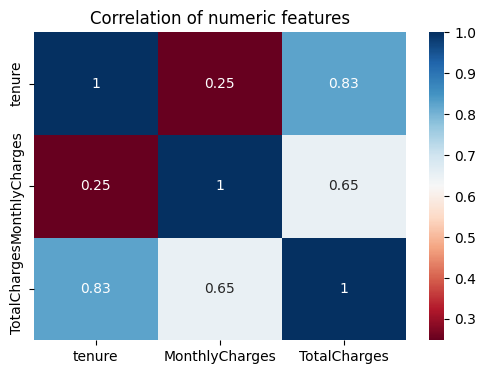

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(data=num_corr_df, annot=True, cmap='RdBu')
plt.title("Correlation of numeric features")
plt.show()

## VIF factor

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_num = num_df.dropna().astype(float)
vif_data = pd.DataFrame()

vif_data['Features'] = X_num.columns
vif_data['VIF'] = [variance_inflation_factor(X_num.values, i)
                   for i in range(X_num.shape[1])]

print(vif_data)

         Features       VIF
0          tenure  6.321802
1  MonthlyCharges  3.360371
2    TotalCharges  8.073814


## Correlation for categorical features

In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

def cramersV(x, y):

  contigency_table = pd.crosstab(x, y)
  chi2 = chi2_contingency(contigency_table)[0]
  N = contigency_table.sum().sum()
  phi2 = chi2/N

  r, k = contigency_table.shape
  phi2_corr = max(0, phi2 - (k-1)*(r-1)/(N-1))

  r_corr = r - (r-1)**2/(N-1)
  k_corr = k - (k-1)**2/(N-1)

  return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

In [ ]:

results = []
for i, col1 in enumerate(categorical_features):
  for j, col2 in enumerate(categorical_features):
    if i < j:
      score = cramersV(df[col1], df[col2])
      results.append({"Feature1": col1, "Feature2": col2, "Score": score})

corr_df = pd.DataFrame(results)
corr_df

,Feature1,Feature2,Score
0,InternetService,Contract,0.206263
1,InternetService,PaymentMethod,0.312434
2,InternetService,MultipleLines,0.396424
3,InternetService,OnlineSecurity,0.724373
4,InternetService,OnlineBackup,0.707084
5,InternetService,DeviceProtection,0.707007
6,InternetService,TechSupport,0.722811
7,InternetService,StreamingTV,0.717003
8,InternetService,StreamingMovies,0.715911
9,Contract,PaymentMethod,0.265898


In [ ]:
df_corr_sym = pd.concat([
    corr_df.rename(columns={"Feature1": 'row', 'Feature2': 'col', 'Score': 'Values'}),
    corr_df.rename(columns={'Feature2': 'row', 'Feature1': 'col', 'Score': 'Values'})
])

corr_matrx = df_corr_sym.pivot(index='row', columns='col', values='Values')

for col in corr_matrx:
  corr_matrx.loc[col, col] = 1

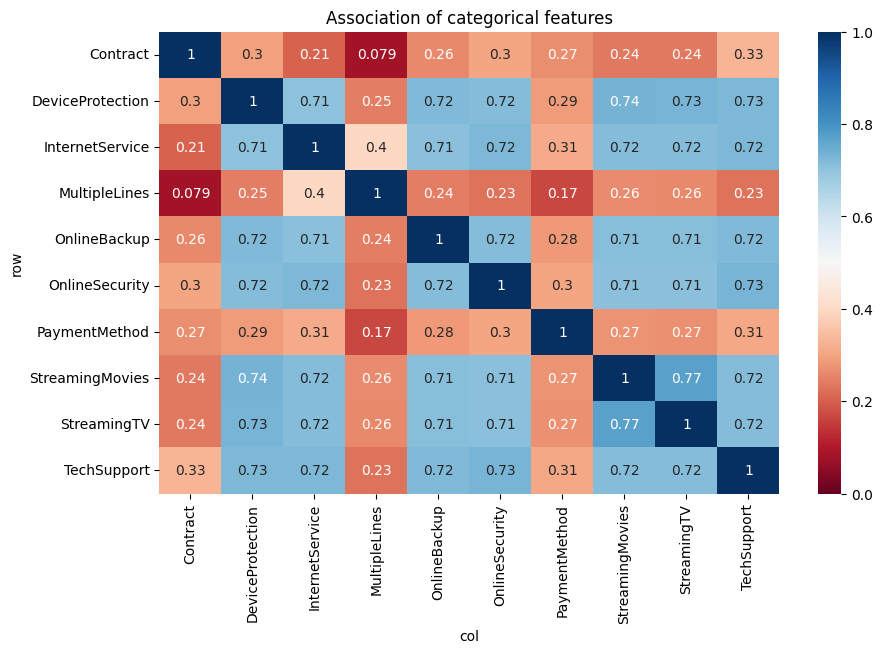

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(data=corr_matrx, annot=True, cmap='RdBu', vmin=0, vmax=1)
plt.title("Association of categorical features")
plt.show()

From the correlation matrix build from cramer's V there is a clear view that InternetService is higly correlated with Techsupport, DeviceProtextion, OnlineBackup & Security and Streaming TV & Movies. So these may consider as add-on, but can't blindly considering it for adds-on but with future tests to confirm it

## Dependency

In [ ]:
addons = ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
cond_pr = {}

for add in addons:
  cond_pr[add] = df.groupby("InternetService", observed=True)[add].apply(lambda x: (x=='Yes').mean())

pd.DataFrame(cond_pr)

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
InternetService,,,,,,
DSL,0.487402,0.448575,0.439901,0.486576,0.395291,0.405204
Fiber optic,0.270995,0.433786,0.438307,0.279716,0.565245,0.565568
No,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Here the DSL customer has more domination in OnlineSecurity, TechSupport. Streaming Services are most prefered Fibre optics by users. DSl users are meant for safety than speed compared to Fibre Optic. OnlineBackup and DeviceProtection are similar in both DSL and Fibre optic. So can't just blindly drop it. The similar group can be aggregrated. The No is all zero which clearly shows that without internet there is no add on services.

## Chi2 test for InternetService vs addons

In [ ]:
for add in addons:
  ct = pd.crosstab(df['InternetService'], df[add])

  chi2, p, dof, _ = chi2_contingency(ct)
  print(add, "chi2 p:", p)
  display(ct)

OnlineSecurity chi2 p: 0.0


OnlineSecurity,No,No internet service,Yes
InternetService,,,
DSL,1241,0,1180
Fiber optic,2257,0,839
No,0,1526,0


OnlineBackup chi2 p: 0.0


OnlineBackup,No,No internet service,Yes
InternetService,,,
DSL,1335,0,1086
Fiber optic,1753,0,1343
No,0,1526,0


DeviceProtection chi2 p: 0.0


DeviceProtection,No,No internet service,Yes
InternetService,,,
DSL,1356,0,1065
Fiber optic,1739,0,1357
No,0,1526,0


TechSupport chi2 p: 0.0


TechSupport,No,No internet service,Yes
InternetService,,,
DSL,1243,0,1178
Fiber optic,2230,0,866
No,0,1526,0


StreamingTV chi2 p: 0.0


StreamingTV,No,No internet service,Yes
InternetService,,,
DSL,1464,0,957
Fiber optic,1346,0,1750
No,0,1526,0


StreamingMovies chi2 p: 0.0


StreamingMovies,No,No internet service,Yes
InternetService,,,
DSL,1440,0,981
Fiber optic,1345,0,1751
No,0,1526,0


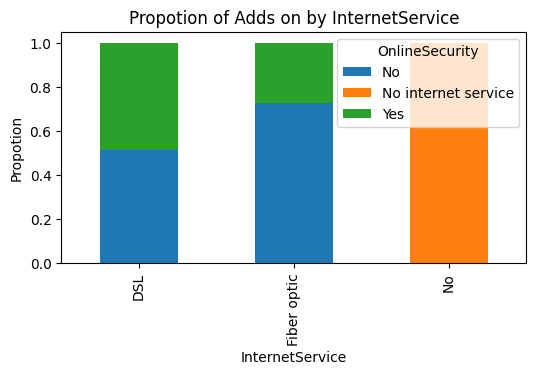

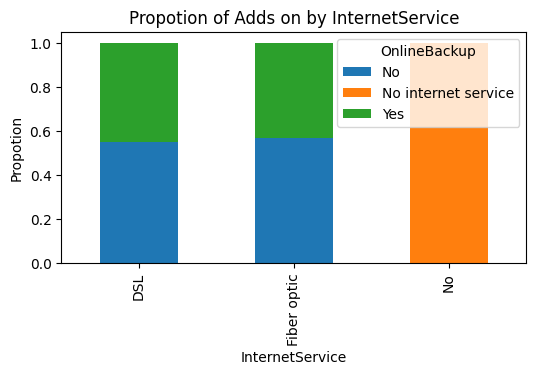

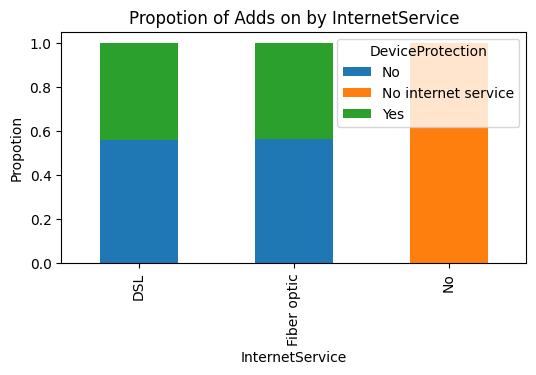

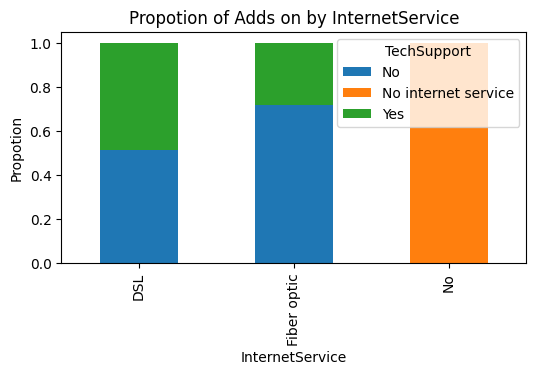

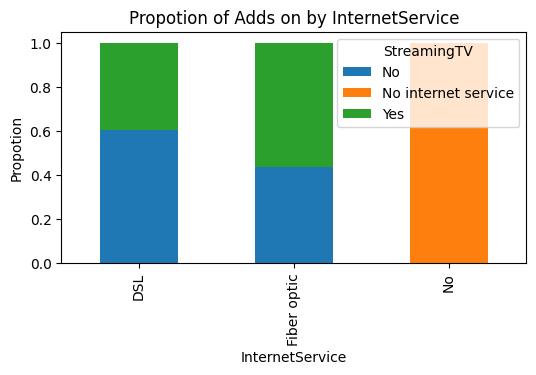

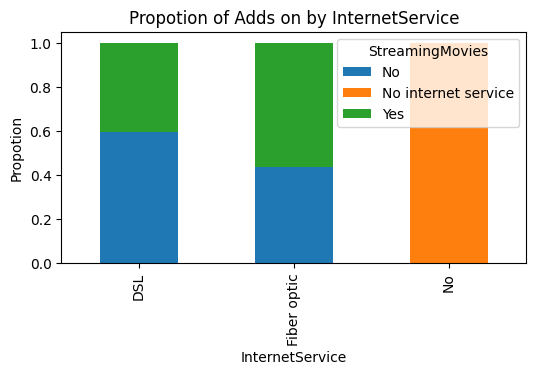

In [ ]:
for add in addons:
  cross = pd.crosstab(df['InternetService'], df[add], normalize='index')
  cross.plot(kind='bar', stacked=True, figsize=(6,3), title=add)
  plt.ylabel("Propotion")
  plt.title("Propotion of Adds on by InternetService")
  plt.show()

## Creating dependency

In [ ]:
df.loc[df['InternetService'] == 'No', addons] = 'No'

In [ ]:
pd.crosstab(df['InternetService'], df['OnlineBackup'], normalize='index')


OnlineBackup,No,Yes
InternetService,,
DSL,0.551425,0.448575
Fiber optic,0.566214,0.433786
No,1.000000,0.000000


In [ ]:
assert (df.loc[df['InternetService'] == 'No', addons] == 'No').all().all()

## Creating new aggregrations

In [ ]:
security_addons = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport"]
streaming_addons = ["StreamingTV", "StreamingMovies"]

In [ ]:
df['num_security_addons'] = df[security_addons].eq('Yes').sum(axis=1)
df['num_streaming_addons'] = df[streaming_addons].eq('Yes').sum(axis=1)

df.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,num_security_addons,num_streaming_addons
0,0,Yes,No,1.0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,0
1,0,No,No,34.0,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,2,0
2,0,No,No,2.0,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2,0
3,0,No,No,45.0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Automatic,42.30,1840.75,No,3,0
4,0,No,No,2.0,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,0


In [ ]:
df['has_security'] = (df['num_security_addons'] > 0).astype(int)
df['has_streaming'] = (df['num_streaming_addons'] > 0).astype(int)

df.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,num_security_addons,num_streaming_addons,has_security,has_streaming
0,0,Yes,No,1.0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,0,1,0
1,0,No,No,34.0,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,2,0,1,0
2,0,No,No,2.0,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2,0,1,0
3,0,No,No,45.0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Automatic,42.30,1840.75,No,3,0,1,0
4,0,No,No,2.0,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,0,0,0


In [ ]:
df = df.drop(columns=['OnlineSecurity',	'OnlineBackup',	'DeviceProtection',	'TechSupport',	'StreamingTV',	'StreamingMovies'], axis=1)

Dropping the add on service features from dataset as it is feature engineered to create adds on which will be more suitable for modelling

### Sanity check for addons for streaming and security

In [ ]:
pd.crosstab(df['InternetService'], df['has_security'], normalize='index')

has_security,0,1
InternetService,,
DSL,0.173069,0.826931
Fiber optic,0.273902,0.726098
No,1.000000,0.000000


In [ ]:
pd.crosstab(df['InternetService'], df['has_streaming'], normalize='index')

has_streaming,0,1
InternetService,,
DSL,0.459727,0.540273
Fiber optic,0.292313,0.707687
No,1.000000,0.000000


From the above sanity checks the DSL users are more security preferred group while the fibre optic groups are more streaming preffered groups.

In [ ]:
df['Fibre_stream_pref'] = ((df['InternetService'] =='Fiber optic') & (df['has_streaming'] == 1)).astype(int)
df['DSL_security_pref'] = ((df['InternetService'] == 'DSL') & (df['has_security'] == 1)).astype(int)

df.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,num_security_addons,num_streaming_addons,has_security,has_streaming,Fibre_stream_pref,DSL_security_pref
0,0,Yes,No,1.0,No phone service,DSL,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,0,1,0,0,1
1,0,No,No,34.0,No,DSL,One year,No,Mailed check,56.95,1889.50,No,2,0,1,0,0,1
2,0,No,No,2.0,No,DSL,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2,0,1,0,0,1
3,0,No,No,45.0,No phone service,DSL,One year,No,Automatic,42.30,1840.75,No,3,0,1,0,0,1
4,0,No,No,2.0,No,Fiber optic,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,0,0,0,0,0


### Split for checks

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X= df.drop(columns='Churn', axis=1)
y = (df['Churn']=='Yes').astype(int)

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y,
                                                  test_size=0.20, stratify=y,
                                                  random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp,
    random_state=42
)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((4225, 17), (1409, 17), (1409, 17), (4225,), (1409,), (1409,))

### Correlation and checks on train split

In [ ]:
X_tr = X_train.copy()
y_tr = y_train.copy()

In [ ]:
pd.crosstab(X_tr['has_security'], y_tr, normalize='index')

Churn,0,1
has_security,,
0,0.699700,0.300300
1,0.757422,0.242578


In [ ]:
pd.crosstab(X_tr['has_streaming'], y_tr, normalize='index')

Churn,0,1
has_streaming,,
0,0.776197,0.223803
1,0.693289,0.306711


In [ ]:
pd.crosstab(X_tr['has_security'], X_tr['has_streaming'])

has_streaming,0,1
has_security,,
0,1322,343
1,787,1773


array([[<Axes: title={'center': 'num_security_addons'}>,
        <Axes: title={'center': 'num_streaming_addons'}>]], dtype=object)

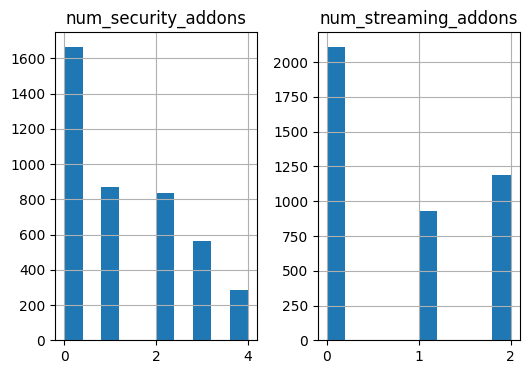

In [ ]:
X_tr[['num_security_addons', 'num_streaming_addons']].hist(figsize=(6,4))

Here from the engineered features has security and has streaming are not correlated. Found the has security customers are less likely to churn. Customers who are having has streaming founds more churning. So these feature engineering products are seems good.

### Pearson correlation for num addons

In [ ]:
X_tr[['num_security_addons', 'num_streaming_addons']].corr(method='pearson')

,num_security_addons,num_streaming_addons
num_security_addons,1.000000,0.475629
num_streaming_addons,0.475629,1.000000


### Correlation for binary columns in addons

In [ ]:
binary_addons = ['has_security', 'has_streaming',	'Fibre_stream_pref',	'DSL_security_pref']
X_tr[binary_addons].corr()

,has_security,has_streaming,Fibre_stream_pref,DSL_security_pref
has_security,1.000000,0.475530,0.258081,0.513860
has_streaming,0.475530,1.000000,0.662976,0.138914
Fibre_stream_pref,0.258081,0.662976,1.000000,-0.423131
DSL_security_pref,0.513860,0.138914,-0.423131,1.000000


### Using Point-biserial for binary and numerical

In [ ]:
from scipy.stats import pointbiserialr

for bin in binary_addons:
  for num in ['num_security_addons', 'num_streaming_addons']:
    r, p = pointbiserialr(X_tr[bin], X_tr[num])
    print(bin,"&", num, '=', r,', p:', np.round(p,1))

has_security & num_security_addons = 0.7976995429419214 , p: 0.0
has_security & num_streaming_addons = 0.467500516125612 , p: 0.0
has_streaming & num_security_addons = 0.4634555071558094 , p: 0.0
has_streaming & num_streaming_addons = 0.9120551204260057 , p: 0.0
Fibre_stream_pref & num_security_addons = 0.17944704059761826 , p: 0.0
Fibre_stream_pref & num_streaming_addons = 0.6397303221346426 , p: 0.0
DSL_security_pref & num_security_addons = 0.49367650605788665 , p: 0.0
DSL_security_pref & num_streaming_addons = 0.10531189389568811 , p: 0.0


### Pairwise association

In [ ]:
for i in ['has_streaming', 'has_security']:
  V = cramersV(X_tr['InternetService'], X_tr[i])
  print(f"Association of InternetService with {i}: {V}")

Association of InternetService with has_streaming: 0.538657179415512
Association of InternetService with has_security: 0.6547763165178533


In [ ]:
pd.crosstab(X_tr['has_security'], X_tr['num_security_addons'], normalize='index')

num_security_addons,0,1,2,3,4
has_security,,,,,
0,1.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.340234,0.326953,0.221094,0.111719


In [ ]:
pd.crosstab(X_tr['has_streaming'], X_tr['num_streaming_addons'], normalize='index')

num_streaming_addons,0,1,2
has_streaming,,,
0,1.0,0.000000,0.000000
1,0.0,0.438091,0.561909


In [ ]:
X_tr = X_tr.drop(columns=['has_security',	'has_streaming'], axis=1)

In [ ]:
X_val = X_val.drop(columns=['has_security',	'has_streaming'], axis=1)
X_test = X_test.drop(columns=['has_security',	'has_streaming'], axis=1)

From the sanity checks and correlation checks i found that the feature engineered column `has_streaming` and `has_security` is highly correlated with its corresponding numerical add ons. Like, the `num_streaming_addons` is having greater than 0 only if has_streaming is 1 and if 0 the addons is also 0. Similar for the security too. So by keeping the both may cause misclassification for models. So better to drop the binary and keep numerical as it will give more signal for models like logistic regression.

In [ ]:
pd.crosstab(X_tr['InternetService'], X_tr['MultipleLines'], normalize='index')

MultipleLines,No,No phone service,Yes
InternetService,,,
DSL,0.426052,0.291723,0.282225
Fiber optic,0.373304,0.000000,0.626696
No,0.769824,0.000000,0.230176


In [ ]:
for i in ['MultipleLines']:
  for j in ['InternetService']:

    asso = cramersV(X_tr[i], X_tr[j])
    print(f"Association for {i} and {j}: {asso}")

Association for MultipleLines and InternetService: 0.39865705028801146


In [ ]:
df.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,num_security_addons,num_streaming_addons,has_security,has_streaming,Fibre_stream_pref,DSL_security_pref
0,0,Yes,No,1.0,No phone service,DSL,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,0,1,0,0,1
1,0,No,No,34.0,No,DSL,One year,No,Mailed check,56.95,1889.50,No,2,0,1,0,0,1
2,0,No,No,2.0,No,DSL,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2,0,1,0,0,1
3,0,No,No,45.0,No phone service,DSL,One year,No,Automatic,42.30,1840.75,No,3,0,1,0,0,1
4,0,No,No,2.0,No,Fiber optic,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,0,0,0,0,0


In [ ]:
pd.crosstab(index=[X_tr['InternetService'], X_tr['MultipleLines']],
            columns=y_tr, normalize='index')

Churn                                    0         1
InternetService MultipleLines                       
DSL             No                0.804140  0.195860
                No phone service  0.741860  0.258140
                Yes               0.901442  0.098558
Fiber optic     No                0.537791  0.462209
                Yes               0.600000  0.400000
No              No                0.917024  0.082976
                Yes               0.961722  0.038278

In [ ]:
X_tr['has_phone'] = (X_tr['MultipleLines'] != 'No phone service').astype(int)
X_tr['has_multipleline'] = (X_tr['MultipleLines'] == 'Yes').astype(int)

In [ ]:
X_val['has_phone'] = (X_val['MultipleLines'] != 'No phone service').astype(int)
X_val['has_multipleline'] = (X_val['MultipleLines'] == 'Yes').astype(int)

In [ ]:
X_test['has_phone'] = (X_test['MultipleLines'] != 'No phone service').astype(int)
X_test['has_multipleline'] = (X_test['MultipleLines'] == 'Yes').astype(int)

In [ ]:
X_tr = X_tr.drop(columns=['MultipleLines'], axis=1)

In [ ]:
X_val = X_val.drop(columns=['MultipleLines'], axis=1)
X_test = X_test.drop(columns=['MultipleLines'], axis=1)

From here, the muultiple lines and internet service is moderately correlated. When looking into the categories of Multiple lines there are people with multiple lines, without multiple lines and also has no phone service. When comparing with the internet types, Fibre optic seem more churners than DSL in having the multiple lines with and without. Also the people with multiplelines seems churners lesser than without.

Action: Making new features for combination of internet type and Multiple lines which will be more easier for model like Logistic Regression

## Preparation for preprocessing

In [ ]:
X_train = X_tr.copy()

In [ ]:
for col in X_train.select_dtypes(include='object').columns:

  X_train[col] = X_train[col].str.strip()
  X_val[col] = X_val[col].str.strip()
  X_test[col] = X_test[col].str.strip()

In [ ]:
for col in ['Partner', 'Dependents', 'PaperlessBilling']:
  for d in (X_train, X_val, X_test):
    d[col] = d[col].map({'Yes': 1, 'No': 0})

In [ ]:
X_tr_noint = X_tr.drop(columns=['InternetService'], axis=1)
X_tr_noint.head()

,SeniorCitizen,Partner,Dependents,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,num_security_addons,num_streaming_addons,Fibre_stream_pref,DSL_security_pref,has_phone,has_multipleline
2312,0,No,No,18.0,One year,No,Mailed check,20.10,401.85,0,0,0,0,1,0
5227,0,No,No,7.0,Month-to-month,No,Electronic check,96.20,639.70,0,2,1,0,1,1
6404,0,No,No,52.0,Two year,Yes,Electronic check,109.30,5731.40,3,2,1,0,1,1
88,0,Yes,Yes,46.0,Two year,Yes,Mailed check,19.95,927.10,0,0,0,0,1,0
6496,1,Yes,No,40.0,Month-to-month,No,Electronic check,101.85,4086.30,1,2,1,0,1,1


In [ ]:
X_val_noint = X_val.drop(columns=['InternetService'], axis=1)
X_val_noint.head()

,SeniorCitizen,Partner,Dependents,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,num_security_addons,num_streaming_addons,Fibre_stream_pref,DSL_security_pref,has_phone,has_multipleline
2103,1,1,0,11.0,Month-to-month,1,Electronic check,70.20,834.70,0,0,0,0,1,0
6096,1,0,0,1.0,Month-to-month,1,Electronic check,70.20,70.20,0,0,0,0,1,0
4286,0,1,0,9.0,Month-to-month,1,Electronic check,88.05,801.30,1,1,1,0,1,1
815,0,0,0,25.0,Month-to-month,1,Mailed check,84.60,2088.05,0,1,1,0,1,1
4297,0,0,0,45.0,Two year,0,Mailed check,73.55,3349.10,2,1,0,1,1,1


In [ ]:
X_test_noint = X_test.drop(columns=['InternetService'], axis=1)
X_test_noint.head()

,SeniorCitizen,Partner,Dependents,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,num_security_addons,num_streaming_addons,Fibre_stream_pref,DSL_security_pref,has_phone,has_multipleline
437,0,1,1,72.0,Two year,1,Automatic,114.05,8468.20,4,2,1,0,1,1
2280,1,0,0,8.0,Month-to-month,1,Automatic,100.15,908.55,1,2,1,0,1,1
2235,0,1,1,41.0,One year,1,Automatic,78.35,3211.20,3,1,0,1,1,1
4460,0,1,0,18.0,Month-to-month,0,Electronic check,78.20,1468.75,2,0,0,0,1,0
3761,0,1,0,72.0,Two year,1,Automatic,82.65,5919.35,3,2,0,1,1,1


## Preprocessing

In [ ]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols

['SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [ ]:
numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()
numeric_cols

['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'num_security_addons',
 'num_streaming_addons',
 'Fibre_stream_pref',
 'DSL_security_pref',
 'has_phone',
 'has_multipleline']

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scalar', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [ ]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scalar', StandardScaler())]),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges',
                                  'num_security_addons', 'num_streaming_addons',
                                  'Fibre_stream_pref', 'DSL_security_pref',
                                  'has_phone', 'has_multipleline']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['SeniorCitizen', 'Partner', 'Dependents',
                                  'InternetService', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])

In [ ]:
X_val.shape

(1409, 16)

In [ ]:
feature_names = preprocessor.get_feature_names_out()

print("Transformed feature count:", len(feature_names))
print("Features:", feature_names)

Transformed feature count: 26
Features: ['num__tenure' 'num__MonthlyCharges' 'num__TotalCharges'
 'num__num_security_addons' 'num__num_streaming_addons'
 'num__Fibre_stream_pref' 'num__DSL_security_pref' 'num__has_phone'
 'num__has_multipleline' 'cat__SeniorCitizen_0' 'cat__SeniorCitizen_1'
 'cat__Partner_0' 'cat__Partner_1' 'cat__Dependents_0' 'cat__Dependents_1'
 'cat__InternetService_DSL' 'cat__InternetService_Fiber optic'
 'cat__InternetService_No' 'cat__Contract_Month-to-month'
 'cat__Contract_One year' 'cat__Contract_Two year'
 'cat__PaperlessBilling_0' 'cat__PaperlessBilling_1'
 'cat__PaymentMethod_Automatic' 'cat__PaymentMethod_Electronic check'
 'cat__PaymentMethod_Mailed check']


In [ ]:
X_train_trf = preprocessor.transform(X_train)
X_val_trf = preprocessor.transform(X_val)

In [ ]:
print("Transformed train label split:", X_train_trf.shape)
print("Transformed validation label split:", X_val_trf.shape)

Transformed train label split: (4225, 26)
Transformed validation label split: (1409, 26)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model= LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_trf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
y_val_pred = model.predict(X_val_trf)
y_val_pred_poba = model.predict_proba(X_val_trf)[:, 1]

In [ ]:
print("prediction on validation:", y_val_pred)
print("Prediction probability on validation:", y_val_pred_poba)

prediction on validation: [1 1 1 ... 1 1 0]
Prediction probability on validation: [0.82522796 0.86808193 0.87432507 ... 0.60963399 0.76693096 0.25850673]


In [ ]:
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("\nAUC:", roc_auc_score(y_val, y_val_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.75      0.76      1409


AUC: 0.7582655196465938


In [ ]:
cat_cols_noint =  X_tr_noint.select_dtypes(['object', 'category']).columns.tolist()
cat_cols_noint

['SeniorCitizen',
 'Partner',
 'Dependents',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [ ]:
preprocessor_noint = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', cat_pipeline, cat_cols_noint)
])

In [ ]:
preprocessor_noint.fit(X_tr_noint, X_val_noint)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scalar', StandardScaler())]),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges',
                                  'num_security_addons', 'num_streaming_addons',
                                  'Fibre_stream_pref', 'DSL_security_pref',
                                  'has_phone', 'has_multipleline']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['SeniorCitizen', 'Partner', 'Dependents',
                                  'Contract', 'PaperlessBilling',
                                  'PaymentMethod'])])

In [ ]:
X_tr_noint_trf = preprocessor_noint.transform(X_tr_noint)
X_val_noint_trf = preprocessor_noint.transform(X_val_noint)

X_tr_noint_trf.shape, X_val_noint_trf.shape

((4225, 23), (1409, 23))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model= LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_tr_noint_trf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
y_val_pred_noint = model.predict(X_val_noint_trf)
y_val_noint_pred_proba = model.predict_proba(X_val_noint_trf)

In [ ]:
print("prediction on validation (No Internet):", y_val_pred_noint)
print("Prediction probability on validation (No internet):", y_val_noint_pred_proba)

prediction on validation (No Internet): [1 1 1 ... 1 1 0]
Prediction probability on validation (No internet): [[0.15265062 0.84734938]
 [0.11686099 0.88313901]
 [0.11857928 0.88142072]
 ...
 [0.3855629  0.6144371 ]
 [0.19272507 0.80727493]
 [0.58536999 0.41463001]]


In [ ]:
print("Classification Report (no internet):\n", classification_report(y_val, y_val_pred_noint))
print("\nAUC (No internet):", roc_auc_score(y_val, y_val_pred_noint))

Classification Report (no internet):
               precision    recall  f1-score   support

           0       0.92      0.66      0.77      1035
           1       0.48      0.84      0.61       374

    accuracy                           0.71      1409
   macro avg       0.70      0.75      0.69      1409
weighted avg       0.80      0.71      0.73      1409


AUC (No internet): 0.7538608592317032


As the accuracy is down when dropping `InternetService`, so dropping is not recommended. Precision is low when both modelling. At first with InternetService, there was only 0.51 as out of predicted churners actually 48 were only churners. When comes to without internet it became 0.48. The precision for both tells that model ables to catch more churners.

In [ ]:
from sklearn.metrics import (
    precision_recall_curve,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score
)



thresholds = np.linspace(0.0, 1.0, 101)
rows = []

for t in thresholds:
  preds = (y_val_pred_poba >= t).astype(int)
  precision = precision_score(y_val, preds, zero_division=0)
  recall = recall_score(y_val, preds, zero_division=0)
  f1 = f1_score(y_val, preds, zero_division=0)

  rows.append({'threshold': t, 'Precision': precision,
               'Recall': recall, 'F1': f1,
               'true_pos': int(((preds == 1) & (y_val == 1)).sum()),
               'false_pos': int(((preds == 1) & (y_val == 0)).sum()),
               'False_neg': int(((preds == 0) & (y_val == 1)).sum()),
               'True_neg': int(((preds == 0) & (y_val == 0)).sum())
               })

metrics_df = pd.DataFrame(rows)


In [ ]:

best_f1 = metrics_df.loc[metrics_df['F1'].idxmax()]
print("Best F1 score:", best_f1.to_dict())


target_recall = 0.80
candidates = metrics_df[metrics_df >= target_recall]

if len(candidates):
  best_recall = candidates.loc[candidates['Precision'].idxmax()]
  print(f"Best Threshold with greater than {target_recall}: {best_recall}")
else:
  print(f"No best thresholds found with greater than {target_recall}")

Best F1 score: {'threshold': 0.65, 'Precision': 0.6019900497512438, 'Recall': 0.6470588235294118, 'F1': 0.6237113402061856, 'true_pos': 242.0, 'false_pos': 160.0, 'False_neg': 132.0, 'True_neg': 875.0}
Best Threshold with greater than 0.8: threshold       0.92
Precision       1.00
Recall           NaN
F1               NaN
true_pos        4.00
false_pos        NaN
False_neg     370.00
True_neg     1035.00
Name: 92, dtype: float64


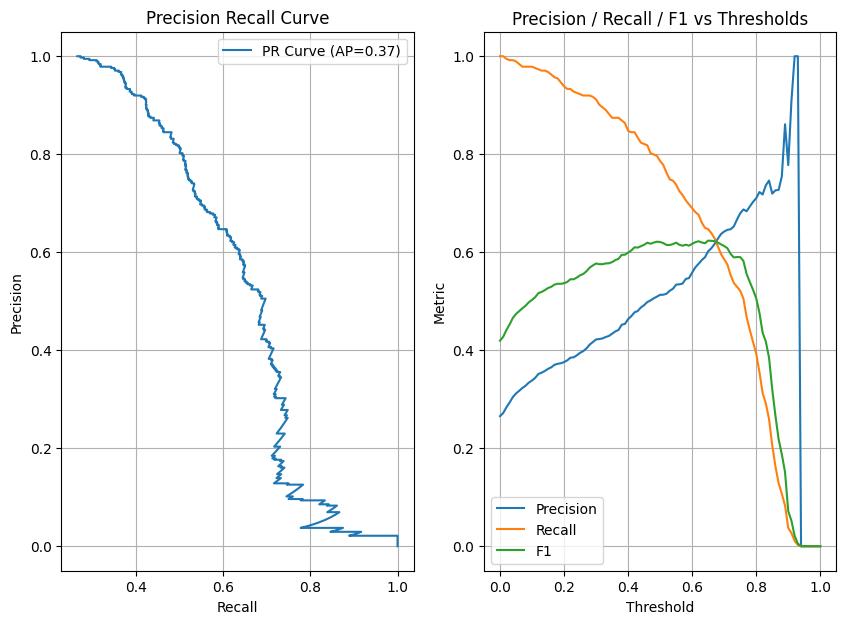

In [ ]:
precisions_c, recall_c, pr_threshold = precision_recall_curve(y_val, y_val_pred_poba)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.plot(precisions_c, recall_c, label=f'PR Curve (AP={np.trapezoid(recall_c, precisions_c):.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(thresholds, metrics_df['Precision'], label='Precision')
plt.plot(thresholds, metrics_df['Recall'], label='Recall')
plt.plot(thresholds, metrics_df['F1'], label='F1')

plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.title("Precision / Recall / F1 vs Thresholds")
plt.grid(True)
plt.legend()

plt.savefig('/content/PRF.png')
plt.show()


In [ ]:
precisions_c, recall_c, pr_threshold = precision_recall_curve(y_val, y_val_pred_poba)

avg_p_score = average_precision_score(y_val, y_val_pred_poba)
auc_trap = np.trapezoid(recall_c, precisions_c)

print("Average precision score:",avg_p_score)
print("Average precision score with trapezioid:",auc_trap)
print("Average of y validation:",y_val.mean())


Average precision score: 0.6376635319331034
Average precision score with trapezioid: 0.3713198264609195
Average of y validation: 0.2654364797728886


From the PR-curve with PR and PR with threshold to detect the best spot where it gives the stable max score. Usage of trapezoid rule to find the area under the curve. The average of y is 0.26 and trapezoid score was 0.37 which refelcts it says something.

## Error Analysis

In [ ]:
best_threshold = 0.65

pred_best = (y_val_pred_poba >= best_threshold).astype(int)
print("Best Thresh classification Report:\n", classification_report(y_val, pred_best))
print("Confusion matrix (TN, FP, FN, TP):\n", confusion_matrix(y_val, pred_best).ravel())

Best Thresh classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      1035
           1       0.60      0.65      0.62       374

    accuracy                           0.79      1409
   macro avg       0.74      0.75      0.74      1409
weighted avg       0.80      0.79      0.80      1409

Confusion matrix (TN, FP, FN, TP):
 [875 160 132 242]


In [ ]:
X_val_copy = X_val.copy()
X_val_copy['y_true'] = y_val.values
X_val_copy['probs'] = y_val_pred_poba
X_val_copy['best preds'] = pred_best

FP = X_val_copy[(X_val_copy['best preds'] == 1) & (X_val_copy['y_true'] == 0)]
FN = X_val_copy[(X_val_copy['best preds'] == 0) & (X_val_copy['y_true'] == 1)]

print("False positive sample:\n")
FP.head()

False positive sample:



,SeniorCitizen,Partner,Dependents,tenure,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,num_security_addons,num_streaming_addons,Fibre_stream_pref,DSL_security_pref,has_phone,has_multipleline,y_true,probs,best preds
2103,1,1,0,11.0,Fiber optic,Month-to-month,1,Electronic check,70.20,834.70,0,0,0,0,1,0,0,0.825228,1
6096,1,0,0,1.0,Fiber optic,Month-to-month,1,Electronic check,70.20,70.20,0,0,0,0,1,0,0,0.868082,1
4286,0,1,0,9.0,Fiber optic,Month-to-month,1,Electronic check,88.05,801.30,1,1,1,0,1,1,0,0.874325,1
815,0,0,0,25.0,Fiber optic,Month-to-month,1,Mailed check,84.60,2088.05,0,1,1,0,1,1,0,0.794582,1
3697,0,1,1,32.0,Fiber optic,Month-to-month,0,Electronic check,89.60,2901.80,1,1,1,0,1,1,0,0.682435,1


In [ ]:
X_val_copy['FP'] = ((X_val_copy['best preds'] == 1) & (X_val_copy['y_true']==0))
X_val_copy['FN'] = ((X_val_copy['best preds'] == 0) & (X_val_copy['y_true']==1))

In [ ]:
print("False Negative samples:\n")
FN.head()

False Negative samples:



,SeniorCitizen,Partner,Dependents,tenure,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,num_security_addons,num_streaming_addons,Fibre_stream_pref,DSL_security_pref,has_phone,has_multipleline,y_true,probs,best preds
4539,0,1,1,67.0,DSL,Two year,1,Electronic check,79.7,5293.40,2,2,0,1,1,1,1,0.062666,0
6290,0,1,0,71.0,Fiber optic,Two year,1,Automatic,93.7,6585.35,0,2,1,0,1,1,1,0.199267,0
6772,0,0,0,38.0,DSL,One year,1,Mailed check,62.3,2354.80,2,1,0,1,1,0,1,0.159146,0
2287,1,1,0,69.0,Fiber optic,Two year,1,Automatic,108.4,7318.20,3,2,1,0,1,1,1,0.178510,0
6746,0,1,1,4.0,DSL,Month-to-month,0,Mailed check,56.5,235.10,2,0,0,1,1,0,1,0.370434,0


In [ ]:
for col in ['Contract', 'PaymentMethod', 'tenure', 'MonthlyCharges', 'num_security_addons',	'num_streaming_addons']:
  if col in X_val_copy.columns:
    print("Column:", col)
    print("FP proportion by group:")
    print(FP[col].value_counts(normalize=True), "\n")
    print("FN proportion by group:")
    print(FN[col].value_counts(normalize=True), "\n")

Column: Contract
FP proportion by group:
Contract
Month-to-month    0.9875
One year          0.0125
Two year          0.0000
Name: proportion, dtype: float64 

FN proportion by group:
Contract
Month-to-month    0.628788
One year          0.272727
Two year          0.098485
Name: proportion, dtype: float64 

Column: PaymentMethod
FP proportion by group:
PaymentMethod
Electronic check    0.66250
Automatic           0.20625
Mailed check        0.13125
Name: proportion, dtype: float64 

FN proportion by group:
PaymentMethod
Automatic           0.454545
Electronic check    0.340909
Mailed check        0.204545
Name: proportion, dtype: float64 

Column: tenure
FP proportion by group:
tenure
1.0     0.09375
2.0     0.06875
5.0     0.05625
9.0     0.04375
11.0    0.04375
7.0     0.04375
3.0     0.03750
8.0     0.03125
16.0    0.03125
37.0    0.03125
4.0     0.03125
19.0    0.02500
30.0    0.02500
14.0    0.02500
23.0    0.02500
32.0    0.02500
25.0    0.02500
39.0    0.01875
10.0    0.01875
27

In [ ]:
def error_rates(df: pd.DataFrame,
                col: str):

  df_error = df.groupby(col, observed=True).agg(
      total= ('y_true', 'size'),
      fp = ('FP', 'sum'),
      fn = ('FN', 'sum')
  ).reset_index()

  df_error['FP_Rate'] = df_error["fp"] / df_error['total']
  df_error['FN_Rate'] = df_error['fn'] / df_error['total']

  df_error = df_error.sort_values('total', ascending=False)
  return df_error

In [ ]:
error_rates(X_val_copy, 'Contract').head(10)

,Contract,total,fp,fn,FP_Rate,FN_Rate
0,Month-to-month,776,158,83,0.203608,0.106959
2,Two year,325,0,13,0.000000,0.040000
1,One year,308,2,36,0.006494,0.116883


In [ ]:
error_rates(X_val_copy, 'PaymentMethod').head(10)

,PaymentMethod,total,fp,fn,FP_Rate,FN_Rate
0,Automatic,622,33,60,0.053055,0.096463
1,Electronic check,481,106,45,0.220374,0.093555
2,Mailed check,306,21,27,0.068627,0.088235


In [ ]:
error_rates(X_val_copy, 'tenure').head(10)

,tenure,total,fp,fn,FP_Rate,FN_Rate
1,1.0,108,15,17,0.138889,0.157407
72,72.0,70,0,0,0.000000,0.000000
2,2.0,44,11,6,0.250000,0.136364
8,8.0,39,5,4,0.128205,0.102564
5,5.0,34,9,1,0.264706,0.029412
3,3.0,33,6,2,0.181818,0.060606
70,70.0,30,0,4,0.000000,0.133333
4,4.0,28,5,2,0.178571,0.071429
71,71.0,28,0,3,0.000000,0.107143
10,10.0,27,3,1,0.111111,0.037037


In [ ]:
X_val_copy['TP'] = ((X_val_copy['best preds'] == 1) & (X_val_copy['y_true'] == 1))
X_val_copy['TN'] = ((X_val_copy['best preds'] == 0) & (X_val_copy['y_true'] == 0))

In [ ]:
def group_metrics(df: pd.DataFrame,
                col: str):

  df_error = df.groupby(col, observed=True).agg(
      total= ('y_true', 'size'),
      fp = ('FP', 'sum'),
      tp = ('TP', 'sum'),
      fn = ('FN', 'sum'),
      tn = ('TN', 'sum')
  ).reset_index()

  df_error['Precision'] = df_error['tp'] / (df_error['tp'] + df_error['fp'])
  df_error['Recall'] = df_error['tp'] / (df_error['tp'] + df_error['fn'])
  df_error['FP_Rate'] = df_error["fp"] / df_error['total']
  df_error['FN_Rate'] = df_error['fn'] / df_error['total']

  return df_error.sort_values('total', ascending=False)

In [ ]:
group_metrics(X_val_copy, 'Contract')

,Contract,total,fp,tp,fn,tn,Precision,Recall,FP_Rate,FN_Rate
0,Month-to-month,776,158,241,83,294,0.604010,0.743827,0.203608,0.106959
2,Two year,325,0,0,13,312,NaN,0.000000,0.000000,0.040000
1,One year,308,2,1,36,269,0.333333,0.027027,0.006494,0.116883


In [ ]:
group_metrics(X_val_copy, 'PaymentMethod')

,PaymentMethod,total,fp,tp,fn,tn,Precision,Recall,FP_Rate,FN_Rate
0,Automatic,622,33,35,60,494,0.514706,0.368421,0.053055,0.096463
1,Electronic check,481,106,177,45,153,0.625442,0.797297,0.220374,0.093555
2,Mailed check,306,21,30,27,228,0.588235,0.526316,0.068627,0.088235


In [ ]:
group_metrics(X_val_copy, 'tenure').head(10)

,tenure,total,fp,tp,fn,tn,Precision,Recall,FP_Rate,FN_Rate
1,1.0,108,15,44,17,32,0.745763,0.721311,0.138889,0.157407
72,72.0,70,0,0,0,70,NaN,NaN,0.000000,0.000000
2,2.0,44,11,20,6,7,0.645161,0.769231,0.250000,0.136364
8,8.0,39,5,11,4,19,0.687500,0.733333,0.128205,0.102564
5,5.0,34,9,11,1,13,0.550000,0.916667,0.264706,0.029412
3,3.0,33,6,12,2,13,0.666667,0.857143,0.181818,0.060606
70,70.0,30,0,0,4,26,NaN,0.000000,0.000000,0.133333
4,4.0,28,5,13,2,8,0.722222,0.866667,0.178571,0.071429
71,71.0,28,0,0,3,25,NaN,0.000000,0.000000,0.107143
10,10.0,27,3,12,1,11,0.800000,0.923077,0.111111,0.037037


In [ ]:
group_metrics(X_val_copy, 'num_security_addons')

,num_security_addons,total,fp,tp,fn,tn,Precision,Recall,FP_Rate,FN_Rate
0,0,545,65,119,36,325,0.646739,0.767742,0.119266,0.066055
1,1,295,68,84,32,111,0.552632,0.724138,0.230508,0.108475
2,2,288,22,36,39,191,0.620690,0.480000,0.076389,0.135417
3,3,184,4,3,21,156,0.428571,0.125000,0.021739,0.114130
4,4,97,1,0,4,92,0.000000,0.000000,0.010309,0.041237


In [ ]:
group_metrics(X_val_copy, 'num_streaming_addons')

,num_streaming_addons,total,fp,tp,fn,tn,Precision,Recall,FP_Rate,FN_Rate
0,0,705,52,91,72,490,0.636364,0.558282,0.073759,0.102128
2,2,388,47,78,44,219,0.624000,0.639344,0.121134,0.113402
1,1,316,61,73,16,166,0.544776,0.820225,0.193038,0.050633


In [ ]:
group_metrics(X_val_copy, 'Fibre_stream_pref')

,Fibre_stream_pref,total,fp,tp,fn,tn,Precision,Recall,FP_Rate,FN_Rate
0,0,943,64,100,92,687,0.609756,0.520833,0.067869,0.097561
1,1,466,96,142,40,188,0.596639,0.780220,0.206009,0.085837


In [ ]:
group_metrics(X_val_copy, 'DSL_security_pref')

,DSL_security_pref,total,fp,tp,fn,tn,Precision,Recall,FP_Rate,FN_Rate
0,0,1029,149,236,84,560,0.612987,0.737500,0.144801,0.081633
1,1,380,11,6,48,315,0.352941,0.111111,0.028947,0.126316


Taking the error analysis by using TN, FP, FN, TP and calculating its PR score. helps in an understanding of featutres with meaningful scores.

In [ ]:
numeric_cols

['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'num_security_addons',
 'num_streaming_addons',
 'Fibre_stream_pref',
 'DSL_security_pref',
 'has_phone',
 'has_multipleline']

## Advanced feature analysis for Logistic Regression

In [ ]:
X_tr = X_train.copy()
X_tr['tenure_bucket'] = pd.cut(X_tr['tenure'], bins=[-1,0,3,12,99], labels=['Zero', '0-3', '4-12', '12+'])
X_tr['avg_monthly_charge'] = X_tr['TotalCharges'] / X_tr['tenure'].replace(0, 1)
X_tr['total_addons'] = X_tr['num_security_addons'].fillna(0).astype(int) + X_tr['num_streaming_addons'].fillna(0).astype(int)
X_tr['contract_payment'] = X_tr['Contract'].astype(str) + '_' + X_tr['PaymentMethod'].astype(str)
X_tr['security_bins'] = pd.cut(X_tr['num_security_addons'].fillna(0), bins=[-1,0,1,2,99], labels=['0','1','2','3+'])
X_tr['streaming_bins'] = pd.cut(X_tr['num_streaming_addons'].fillna(0), bins=[-1,0,1,2,99], labels=['0','1','2','3+'])
X_tr['new_customers'] = (X_tr['tenure'] <= 3).astype(int)

In [ ]:
X_v = X_val.copy()
X_v['tenure_bucket'] = pd.cut(X_v['tenure'], bins=[-1,0,3,12,99], labels=['Zero', '0-3', '4-12', '12+'])
X_v['avg_monthly_charge'] = X_v['TotalCharges'] / X_v['tenure'].replace(0, 1)
X_v['total_addons'] = X_v['num_security_addons'].fillna(0).astype(int) + X_v['num_streaming_addons'].fillna(0).astype(int)
X_v['contract_payment'] = X_v['Contract'].astype(str) + '_' + X_v['PaymentMethod'].astype(str)
X_v['security_bins'] = pd.cut(X_v['num_security_addons'].fillna(0), bins=[-1,0,1,2,99], labels=['0','1','2','3+'])
X_v['streaming_bins'] = pd.cut(X_v['num_streaming_addons'].fillna(0), bins=[-1,0,1,2,99], labels=['0','1','2','3+'])
X_v['new_customers'] = (X_v['tenure'] <= 3).astype(int)

In [ ]:
X_ts = X_test.copy()
X_ts['tenure_bucket'] = pd.cut(X_ts['tenure'], bins=[-1,0,3,12,99], labels=['Zero', '0-3', '4-12', '12+'])
X_ts['avg_monthly_charge'] = X_ts['TotalCharges'] / X_ts['tenure'].replace(0, 1)
X_ts['total_addons'] = X_ts['num_security_addons'].fillna(0).astype(int) + X_ts['num_streaming_addons'].fillna(0).astype(int)
X_ts['contract_payment'] = X_ts['Contract'].astype(str) + '_' + X_ts['PaymentMethod'].astype(str)
X_ts['security_bins'] = pd.cut(X_ts['num_security_addons'].fillna(0), bins=[-1,0,1,2,99], labels=['0','1','2','3+'])
X_ts['streaming_bins'] = pd.cut(X_ts['num_streaming_addons'].fillna(0), bins=[-1,0,1,2,99], labels=['0','1','2','3+'])
X_ts['new_customers'] = (X_ts['tenure'] <= 3).astype(int)

In [ ]:
X_tr = X_tr.drop(columns=['num_security_addons',	'num_streaming_addons'], axis=1)
X_v = X_v.drop(columns=['num_security_addons',	'num_streaming_addons'], axis=1)
X_ts = X_ts.drop(columns=['num_security_addons',	'num_streaming_addons'], axis=1)

X_tr.head()

,SeniorCitizen,Partner,Dependents,tenure,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Fibre_stream_pref,DSL_security_pref,has_phone,has_multipleline,tenure_bucket,avg_monthly_charge,total_addons,contract_payment,security_bins,streaming_bins,new_customers
2312,0,0,0,18.0,No,One year,0,Mailed check,20.10,401.85,0,0,1,0,12+,22.325000,0,One year_Mailed check,0,0,0
5227,0,0,0,7.0,Fiber optic,Month-to-month,0,Electronic check,96.20,639.70,1,0,1,1,4-12,91.385714,2,Month-to-month_Electronic check,0,2,0
6404,0,0,0,52.0,Fiber optic,Two year,1,Electronic check,109.30,5731.40,1,0,1,1,12+,110.219231,5,Two year_Electronic check,3+,2,0
88,0,1,1,46.0,No,Two year,1,Mailed check,19.95,927.10,0,0,1,0,12+,20.154348,0,Two year_Mailed check,0,0,0
6496,1,1,0,40.0,Fiber optic,Month-to-month,0,Electronic check,101.85,4086.30,1,0,1,1,12+,102.157500,3,Month-to-month_Electronic check,1,2,0


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [ ]:
num_cols = X_tr.select_dtypes(include='number').columns.tolist()
num_cols

['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'Fibre_stream_pref',
 'DSL_security_pref',
 'has_phone',
 'has_multipleline',
 'avg_monthly_charge',
 'total_addons',
 'new_customers']

In [ ]:
cat_cols = X_tr.select_dtypes(include=('category', 'object')).columns.tolist()
cat_cols

['SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'tenure_bucket',
 'contract_payment',
 'security_bins',
 'streaming_bins']

In [ ]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scalar', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('OHE', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [ ]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scalar', StandardScaler())]),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges',
                                  'Fibre_stream_pref', 'DSL_security_pref',
                                  'has_phone', 'has_multipleline',
                                  'avg_monthly_charge', 'total_addons',
                                  'new_customers']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('OHE',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['SeniorCitizen', 'Partner', 'Dependents',
                                  'InternetService', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod',
                                  'tenure_bucket', 'contract_payment',
                                  'security_bins', 'streaming_bins'])])

In [ ]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf_model', LogisticRegression(solver='saga', penalty='l2', max_iter=1000, class_weight='balanced', random_state=42))
])

model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'Fibre_stream_pref',
                                                   'DSL_security_pref',
                                                   'has_phone',
                                                   'has_multipleline',
                                                   'avg_monthly_charge',
                                                   'total_addons',
                                                   'new_customers']),
                                                 ('cat',
                                                  Pipeline(steps...
                                                                                 strategy='constant')),
                                                                  ('OHE',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'tenure_bucket',
                                                   'contract_payment',
                                                   'security_bins',
                                                   'streaming_bins'])])),
                ('clf_model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42, solver='saga'))])

In [ ]:
param_grid = {
    'clf_model__C': [0.01, 0.1, 1.0, 10.0],
    'clf_model__penalty': ['l2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model_pipeline, param_grid, scoring='average_precision', cv=cv, n_jobs=-1)
grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scalar',
                                                                                          StandardScaler())]),
                                                                         ['tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'Fibre_stream_pref',
                                                                          'DSL_security_pref',
                                                                          'has_phone',
                                                                          'has_multip...
                                                                          'InternetService',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'tenure_bucket',
                                                                          'contract_payment',
                                                                          'security_bins',
                                                                          'streaming_bins'])])),
                                       ('clf_model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf_model__C': [0.01, 0.1, 1.0, 10.0],
                         'clf_model__penalty': ['l2']},
             scoring='average_precision')

In [ ]:
grid_search.fit(X_tr, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scalar',
                                                                                          StandardScaler())]),
                                                                         ['tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'Fibre_stream_pref',
                                                                          'DSL_security_pref',
                                                                          'has_phone',
                                                                          'has_multip...
                                                                          'InternetService',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'tenure_bucket',
                                                                          'contract_payment',
                                                                          'security_bins',
                                                                          'streaming_bins'])])),
                                       ('clf_model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf_model__C': [0.01, 0.1, 1.0, 10.0],
                         'clf_model__penalty': ['l2']},
             scoring='average_precision')

In [ ]:
print("Best AP score:", grid_search.best_score_, "Best params:", grid_search.best_params_)

Best AP score: 0.6701421745675038 Best params: {'clf_model__C': 0.1, 'clf_model__penalty': 'l2'}


In [ ]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, classification_report,
    confusion_matrix
)


best_estm = grid_search.best_estimator_

prob_test = best_estm.predict_proba(X_v)[:,1]
ap_test = average_precision_score(y_val, prob_test)
auc_test = roc_auc_score(y_val, prob_test)

print("Test AP:", ap_test, "Test ROC-AUC:", auc_test)

Test AP: 0.6492459968657985 Test ROC-AUC: 0.8401805781601177


In [ ]:
pre = best_estm.named_steps['preprocessor']
feature_names = pre.get_feature_names_out()
coefficients = best_estm.named_steps['clf_model'].coef_[0]
print("Feature names:", feature_names)

Feature names: ['num__tenure' 'num__MonthlyCharges' 'num__TotalCharges'
 'num__Fibre_stream_pref' 'num__DSL_security_pref' 'num__has_phone'
 'num__has_multipleline' 'num__avg_monthly_charge' 'num__total_addons'
 'num__new_customers' 'cat__SeniorCitizen_1' 'cat__Partner_1'
 'cat__Dependents_1' 'cat__InternetService_Fiber optic'
 'cat__InternetService_No' 'cat__Contract_One year'
 'cat__Contract_Two year' 'cat__PaperlessBilling_1'
 'cat__PaymentMethod_Electronic check' 'cat__PaymentMethod_Mailed check'
 'cat__tenure_bucket_12+' 'cat__tenure_bucket_4-12'
 'cat__tenure_bucket_Zero'
 'cat__contract_payment_Month-to-month_Electronic check'
 'cat__contract_payment_Month-to-month_Mailed check'
 'cat__contract_payment_One year_Automatic'
 'cat__contract_payment_One year_Electronic check'
 'cat__contract_payment_One year_Mailed check'
 'cat__contract_payment_Two year_Automatic'
 'cat__contract_payment_Two year_Electronic check'
 'cat__contract_payment_Two year_Mailed check' 'cat__security_bins_1

In [ ]:
coefficient_df = pd.DataFrame({'Feature': feature_names, 'Coefficients': coefficients})
coefficient_df['abs_coefficient'] = coefficient_df['Coefficients'].abs()
coefficient_df['oddsrate'] = np.exp(coefficient_df['Coefficients'])
coefficient_df['pct_changes'] = (coefficient_df['oddsrate'] - 1) *100
coefficient_df.sort_values('abs_coefficient', ascending=False)

,Feature,Coefficients,abs_coefficient,oddsrate,pct_changes
16,cat__Contract_Two year,-1.004578,1.004578,0.366199,-63.380077
14,cat__InternetService_No,-0.551769,0.551769,0.575930,-42.406997
1,num__MonthlyCharges,0.527503,0.527503,1.694696,69.469621
28,cat__contract_payment_Two year_Automatic,-0.459422,0.459422,0.631648,-36.835163
0,num__tenure,-0.443476,0.443476,0.641802,-35.819831
30,cat__contract_payment_Two year_Mailed check,-0.397538,0.397538,0.671972,-32.802751
15,cat__Contract_One year,-0.390143,0.390143,0.676960,-32.303980
35,cat__streaming_bins_2,0.351322,0.351322,1.420945,42.094512
25,cat__contract_payment_One year_Automatic,-0.334826,0.334826,0.715462,-28.453775
17,cat__PaperlessBilling_1,0.300920,0.300920,1.351101,35.110065


Coefficients tells the story of churns when taken oddsratio and the percentage of churn with direction.

### Per-group performance and error analysis

In [ ]:
y_pred_test = (prob_test >= 0.5).astype(int)
X_vl = X_v.copy()
X_vl['y_true'] = y_val
X_vl['prob'] = prob_test
X_vl['pred'] = y_pred_test

### Threshold tuning

In [ ]:
from sklearn.metrics import f1_score

threshold = np.linspace(0, 1, 101)
f1_scs = [f1_score(y_val, (prob_test >= t).astype(int)) for t in thresholds]
best_t = threshold[np.argmax(f1_scs)]

print("Best Threshold:", best_t)

Best Threshold: 0.62


In [ ]:
y_val_pred = (prob_test >= best_t).astype(int)
print("Classification Report:", classification_report(y_val, y_val_pred))

Classification Report:               precision    recall  f1-score   support

           0       0.88      0.83      0.86      1035
           1       0.60      0.68      0.64       374

    accuracy                           0.79      1409
   macro avg       0.74      0.76      0.75      1409
weighted avg       0.80      0.79      0.80      1409



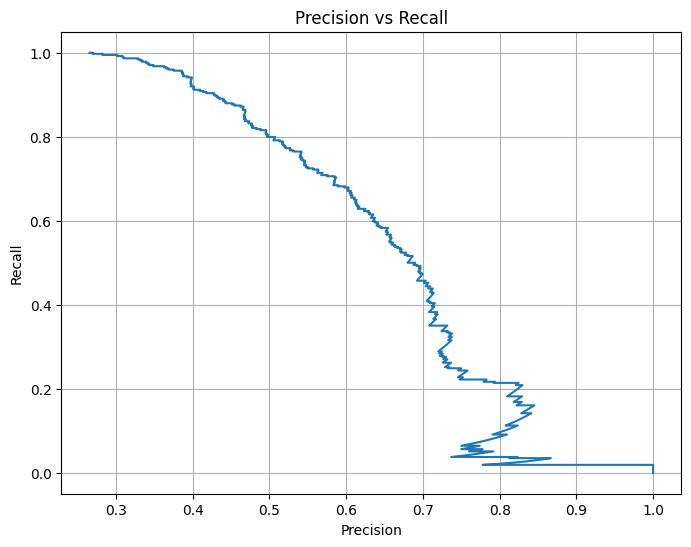

In [ ]:
prec, rec, thresh = precision_recall_curve(y_val, prob_test)

plt.figure(figsize=(8,6))
plt.plot(prec, rec)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision vs Recall")
plt.grid(True)
plt.show()

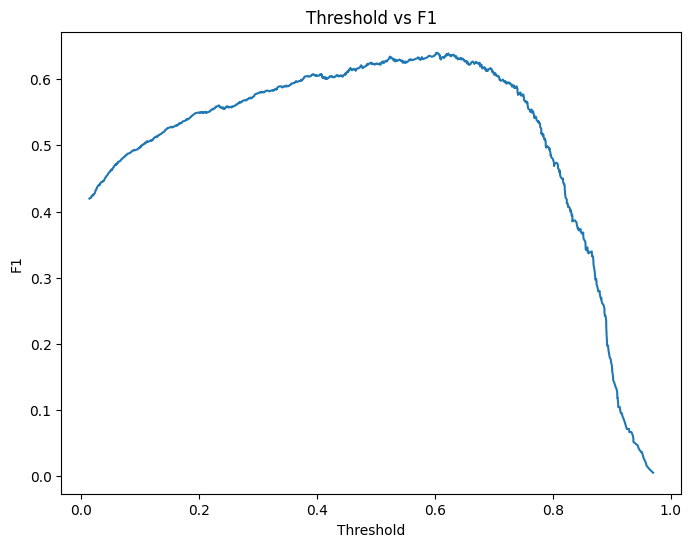

In [ ]:
f1 = 2 * (prec * rec) / (prec + rec + 1e-6)

plt.figure(figsize=(8,6))
plt.plot(thresh, f1[:-1])
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Threshold vs F1")
plt.show()

As from the intial LR model using GridSearch CV as hyperparameter tuning startegy, the model gave moderate results. From the metrics with threshold tuning, the predictions became slight improved. As from looking into, the recall predicted as 0.68 which is moderate. As for churn prediction, the better recall is more valued. So furthur analysis needed to increase the performance of model.

### Probability Calibration

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.frozen import FrozenEstimator

frozen_best = FrozenEstimator(best_estm)
caliborator = CalibratedClassifierCV(frozen_best, method='sigmoid')
caliborator.fit(X_tr, y_tr)
probs_ts_cal = caliborator.predict_proba(X_v)[:, 1]

print("Predicted by caliborator:", probs_ts_cal)

Predicted by caliborator: [0.5833272  0.79550287 0.70567093 ... 0.37591663 0.62788724 0.0855386 ]


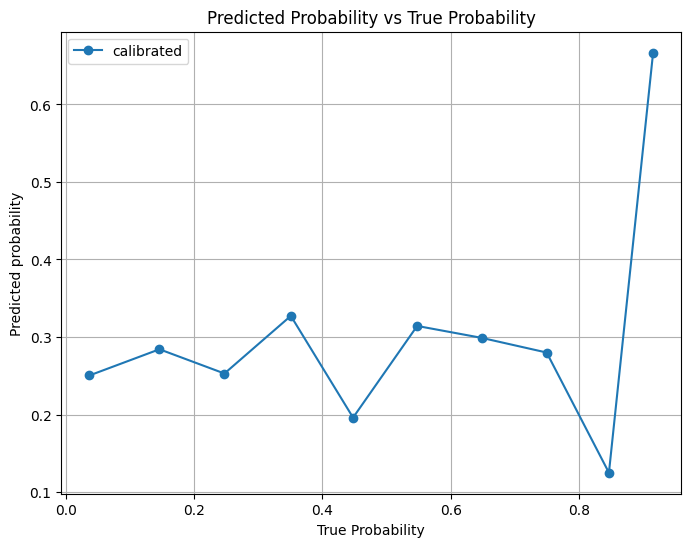

In [ ]:
true_prob, pred_prob = calibration_curve(y_test, probs_ts_cal, n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(pred_prob, true_prob, marker='o', label='calibrated')
plt.xlabel("True Probability")
plt.ylabel("Predicted probability")
plt.title("Predicted Probability vs True Probability")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import brier_score_loss
brier_uncal = brier_score_loss(y_val, best_estm.predict_proba(X_v)[:, 1])
brier_cal = brier_score_loss(y_val, probs_ts_cal)

print("Brier Score without calibrated:", brier_uncal)
print("Brier Score with calibration:", brier_cal)

Brier Score without calibrated: 0.1642231606902821
Brier Score with calibration: 0.13638919753190615


In [ ]:
prec_lr, rec_lr, thresh_lr = precision_recall_curve(y_val, probs_ts_cal)

f1_lr = 2 * prec_lr * rec_lr / (prec_lr + rec_lr + 1e-12)
best_idx_rf = np.argmax(f1_lr[:-1])
best_thrsh_lr = thresh_lr[best_idx_rf]

print("Best Threshold using calibration:", best_thrsh_lr)

Best Threshold using calibration: 0.35636696416275937


In [ ]:
y_val_pred_lr = (probs_ts_cal >= best_thrsh_lr).astype(int)
print("Classification Report:\n\n", classification_report(y_val, y_val_pred_lr))

Classification Report:

               precision    recall  f1-score   support

           0       0.89      0.82      0.85      1035
           1       0.59      0.71      0.64       374

    accuracy                           0.79      1409
   macro avg       0.74      0.76      0.75      1409
weighted avg       0.81      0.79      0.79      1409



From the calibration curve, there are differences between true probabailities and predicted probabailities. By threshold tuning from precision recall curve the recall got increased.

In [ ]:
from sklearn.inspection import permutation_importance


# ohe = best_estm.named_steps['preprocessor'].named_transformers_['cat']
# cat_feat = ohe.get_feature_names_out(cat_cols)
# num_feat = num_cols
# all_features = list(cat_feat) + list(num_feat)


permut = permutation_importance(best_estm, X_v, y_val, scoring='average_precision', n_repeats=10, random_state=42)
imp = pd.DataFrame({'feature': grid_search.feature_names_in_, 'importance': permut.importances_mean,
                    'Std': permut.importances_std}).sort_values('importance', ascending=False)

In [ ]:
imp

,feature,importance,Std
8,MonthlyCharges,0.074665,0.010415
3,tenure,0.048017,0.009902
20,new_customers,0.027151,0.009606
4,InternetService,0.026573,0.006764
5,Contract,0.022702,0.006712
17,contract_payment,0.013472,0.008384
19,streaming_bins,0.013420,0.004738
16,total_addons,0.010943,0.003477
13,has_multipleline,0.009975,0.002891
6,PaperlessBilling,0.009644,0.003505


In [ ]:
best_estm.named_steps['preprocessor']

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scalar', StandardScaler())]),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges',
                                  'Fibre_stream_pref', 'DSL_security_pref',
                                  'has_phone', 'has_multipleline',
                                  'avg_monthly_charge', 'total_addons',
                                  'new_customers']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('OHE',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['SeniorCitizen', 'Partner', 'Dependents',
                                  'InternetService', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod',
                                  'tenure_bucket', 'contract_payment',
                                  'security_bins', 'streaming_bins'])])

### Hold out test

In [ ]:
X_trval = pd.concat([X_tr, X_v])
y_trval = pd.concat([y_train, y_val])

In [ ]:
best_estm.fit(X_trval, y_trval)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'Fibre_stream_pref',
                                                   'DSL_security_pref',
                                                   'has_phone',
                                                   'has_multipleline',
                                                   'avg_monthly_charge',
                                                   'total_addons',
                                                   'new_customers']),
                                                 ('cat',
                                                  Pipeline(steps...
                                                                                 strategy='constant')),
                                                                  ('OHE',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'tenure_bucket',
                                                   'contract_payment',
                                                   'security_bins',
                                                   'streaming_bins'])])),
                ('clf_model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='saga'))])

In [ ]:
y_prob_test = best_estm.predict_proba(X_ts)[:, 1]
y_pred_test = (y_prob_test >= best_t).astype(int)

print("Test ROC-AUC score:", roc_auc_score(y_test, y_pred_test))
print("Test PR-AUC:", average_precision_score(y_test, y_pred_test))
print("Test brier score:", brier_score_loss(y_test, y_pred_test))
print("\n Classification Report on test:\n", classification_report(y_test, y_pred_test))

Test ROC-AUC score: 0.7540985300576094
Test PR-AUC: 0.48138307065496133
Test brier score: 0.2157558552164656

 Classification Report on test:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85      1035
           1       0.58      0.69      0.63       374

    accuracy                           0.78      1409
   macro avg       0.73      0.75      0.74      1409
weighted avg       0.80      0.78      0.79      1409



### SMOTE

In [ ]:
from imblearn.pipeline import Pipeline as pipe
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
], remainder='drop')

smote = SMOTE(random_state=42)
clf = LogisticRegression(solver='saga', penalty='l2',
                         max_iter=1000, random_state=42,
                         class_weight='balanced')
clf

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='saga')

In [ ]:
pipeline = pipe([
    ('preprocess', preprocessor),
    ('smote', smote),
    ('clf', clf)
])


param_grid = {
    'smote__k_neighbors': [3,5, 7],
    'smote__sampling_strategy': [0.5, 0.75, 1.0],
    'clf__C': [0.01, 0.1, 1.0],
    'clf__penalty': ['l2']
}

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid,
                    scoring='average_precision',
                    cv=cv, n_jobs=-1, verbose=1)

grid.fit(X_tr, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'Fibre_stream_pref',
                                                                          'DSL_security_pref',
                                                                          'has_phone',
                                                                          'has_multipleline',
                                                                          'avg_monthly_charge',
                                                                          'total_addons',
                                                                          'new_customers']),
                                                                        ('cat',
                                                                         OneHotE...
                                                                          'contract_payment',
                                                                          'security_bins',
                                                                          'streaming_bins'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1.0], 'clf__penalty': ['l2'],
                         'smote__k_neighbors': [3, 5, 7],
                         'smote__sampling_strategy': [0.5, 0.75, 1.0]},
             scoring='average_precision', verbose=1)

In [ ]:
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Best Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.5}
Best Score: 0.671700487796801


In [ ]:
best_estm_sm = grid.best_estimator_

prob_val_sm = best_estm_sm.predict_proba(X_v)[:, 1]
ap_score_sm = average_precision_score(y_val, prob_val_sm)
roc_score_sm = roc_auc_score(y_val, prob_val_sm)

print("Average precision score on smote:", ap_score_sm)
print("AUC score on smote:", roc_score_sm)

Average precision score on smote: 0.6507454044080735
AUC score on smote: 0.8413921826965305


In [ ]:
prepr = best_estm_sm.named_steps['preprocess']
ft_names = prepr.get_feature_names_out()
coefficient_sm = best_estm_sm.named_steps['clf'].coef_[0]

In [ ]:
coeff_sm_df = pd.DataFrame({'Features': ft_names, 'coefficients': coefficient_sm})
coeff_sm_df['abs coefficients'] = coeff_sm_df['coefficients'].abs()
coeff_sm_df['OddsRatio'] = np.exp(coeff_sm_df['coefficients'])
coeff_sm_df['pct changes'] = (coeff_sm_df['OddsRatio'] - 1)*100
coeff_sm_df.sort_values('abs coefficients', ascending=False)

,Features,coefficients,abs coefficients,OddsRatio,pct changes
16,cat__Contract_Two year,-1.054553,1.054553,0.348348,-65.165178
14,cat__InternetService_No,-0.589574,0.589574,0.554564,-44.543642
1,num__MonthlyCharges,0.551915,0.551915,1.736576,73.657577
0,num__tenure,-0.503901,0.503901,0.604169,-39.583096
15,cat__Contract_One year,-0.430937,0.430937,0.649900,-35.010044
30,cat__contract_payment_Two year_Mailed check,-0.423332,0.423332,0.654861,-34.513882
28,cat__contract_payment_Two year_Automatic,-0.404310,0.404310,0.667437,-33.256261
35,cat__streaming_bins_2,0.380617,0.380617,1.463187,46.318747
17,cat__PaperlessBilling_1,0.352687,0.352687,1.422885,42.288514
13,cat__InternetService_Fiber optic,0.334406,0.334406,1.397110,39.711005


### Threshold Tuning

In [ ]:
from sklearn.metrics import f1_score

thresholds_sm = np.linspace(0, 1, 101)
f1_sc_sm = [f1_score(y_val, (prob_val_sm >= t).astype(int)) for t in thresholds_sm]
best_sc_sm = thresholds_sm[np.argmax(f1_sc_sm)]

print("Best threshold SMOTE:", best_sc_sm)

Best threshold SMOTE: 0.64


In [ ]:
y_pred_val = (prob_val_sm >= best_sc_sm).astype(int)
print("Classification Report:\n\n", classification_report(y_val, y_pred_val))

Classification Report:

               precision    recall  f1-score   support

           0       0.87      0.85      0.86      1035
           1       0.62      0.66      0.64       374

    accuracy                           0.80      1409
   macro avg       0.75      0.76      0.75      1409
weighted avg       0.81      0.80      0.80      1409



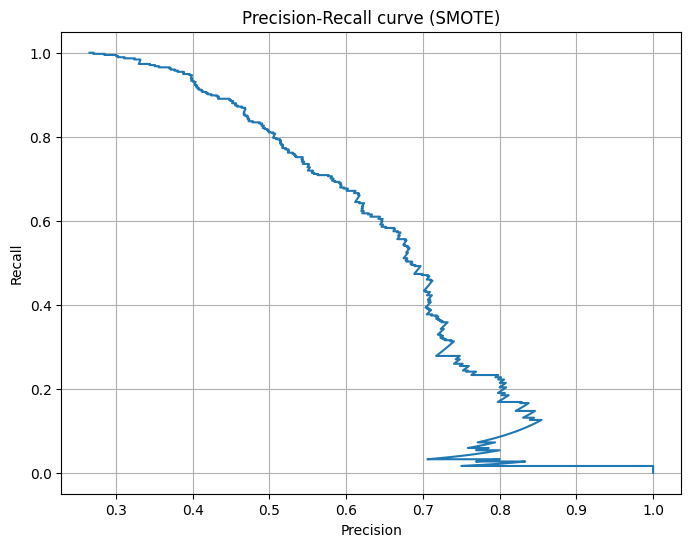

In [ ]:
prec_sm, recall_sm, thrsh_sm = precision_recall_curve(y_val, prob_val_sm)

plt.figure(figsize=(8,6))
plt.plot(prec_sm, recall_sm)
plt.xlabel('Precision')
plt.ylabel("Recall")
plt.title("Precision-Recall curve (SMOTE)")
plt.grid(True)
plt.show()

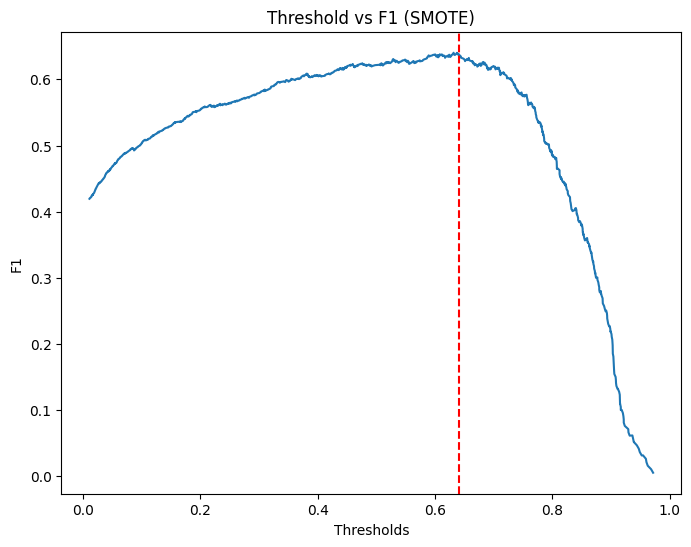

In [ ]:
f1_sm = 2 * (prec_sm * recall_sm) / (prec_sm + recall_sm + 1e-8)

plt.figure(figsize=(8,6))
plt.plot(thrsh_sm, f1_sm[:-1])
plt.axvline(best_sc_sm, color='red', linestyle='--', label='Chosen threshold')
plt.xlabel("Thresholds")
plt.ylabel("F1")
plt.title("Threshold vs F1 (SMOTE)")
plt.show()

### Calibration on SMOTE

In [ ]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator

estm = FrozenEstimator(best_estm_sm)
caliborator_sm = CalibratedClassifierCV(estm, method='sigmoid')
caliborator_sm.fit(X_v, y_val)

CalibratedClassifierCV(estimator=FrozenEstimator(estimator=Pipeline(steps=[('preprocess',
                                                                            ColumnTransformer(transformers=[('num',
                                                                                                             StandardScaler(),
                                                                                                             ['tenure',
                                                                                                              'MonthlyCharges',
                                                                                                              'TotalCharges',
                                                                                                              'Fibre_stream_pref',
                                                                                                              'DSL_security_pref',
                                                                                                              'has_phone',
                                                                                                              'has_multipleline',
                                                                                                              'avg_monthly_charge',
                                                                                                              'total_addons',
                                                                                                              'new_customers']),
                                                                                                            ('cat',
                                                                                                             OneHotEncoder(drop='first',
                                                                                                                           hand...
                                                                                                             ['SeniorCitizen',
                                                                                                              'Partner',
                                                                                                              'Dependents',
                                                                                                              'InternetService',
                                                                                                              'Contract',
                                                                                                              'PaperlessBilling',
                                                                                                              'PaymentMethod',
                                                                                                              'tenure_bucket',
                                                                                                              'contract_payment',
                                                                                                              'security_bins',
                                                                                                              'streaming_bins'])])),
                                                                           ('smote',
                                                                            SMOTE(k_neighbors=3,
                                                                                  random_state=42,
                                                                                  sampling_strategy=0.5)),
                                                                           ('clf',
                                                                            LogisticRegression(C=0.1,
                                     

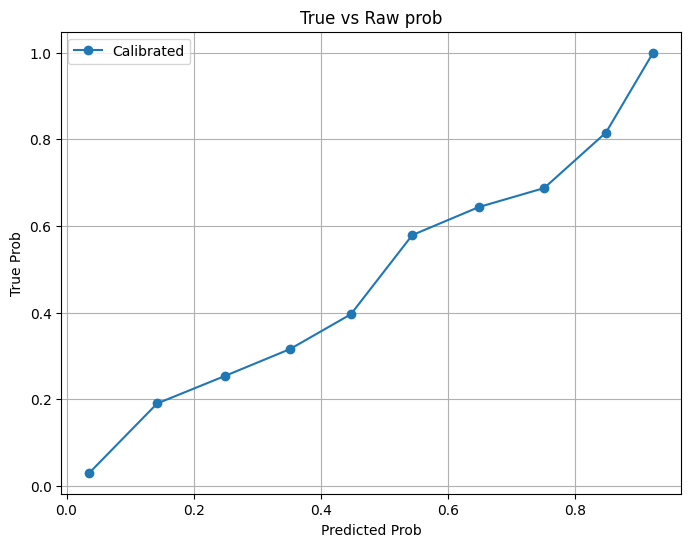

In [ ]:
cal_probval_sm = caliborator.predict_proba(X_ts)[:, 1]

true_prob_sm, pred_prob_sm = calibration_curve(y_test, cal_probval_sm, n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(pred_prob_sm, true_prob_sm, marker='o', label='Calibrated')
plt.xlabel("Predicted Prob")
plt.ylabel("True Prob")
plt.title("True vs Raw prob")
plt.legend()
plt.grid(True)
plt.show()

### Brier score loss

In [ ]:
from sklearn.metrics import brier_score_loss

brier_uncal_sm = brier_score_loss(y_test, best_estm_sm.predict_proba(X_ts)[:,1])
brier_cal_sm = brier_score_loss(y_test, cal_probval_sm)

print("Brier Score with uncalibrated (SMOTE):", brier_uncal_sm)
print("Brier Score with calibrated (SMOTE):", brier_cal_sm)

Brier Score with uncalibrated (SMOTE): 0.16364395790888672
Brier Score with calibrated (SMOTE): 0.13600887775497172


In [ ]:
from sklearn.inspection import permutation_importance

imp_sm = permutation_importance(best_estm_sm, X_v, y_val,
                                scoring='average_precision',
                                n_repeats=20, n_jobs=-1)
imp_sm_df = pd.DataFrame({'Features': best_estm_sm.feature_names_in_,
                          'Importance mean': imp_sm.importances_mean,
                          'Importance std': imp_sm.importances_std
                          })

imp_sm_df.sort_values('Importance mean', ascending=False)

,Features,Importance mean,Importance std
8,MonthlyCharges,0.065357,0.013473
3,tenure,0.061703,0.011968
20,new_customers,0.033433,0.010247
5,Contract,0.027963,0.004917
4,InternetService,0.026087,0.007491
17,contract_payment,0.018246,0.005325
16,total_addons,0.018231,0.006567
6,PaperlessBilling,0.012630,0.004317
19,streaming_bins,0.010690,0.004895
12,has_phone,0.010384,0.007159


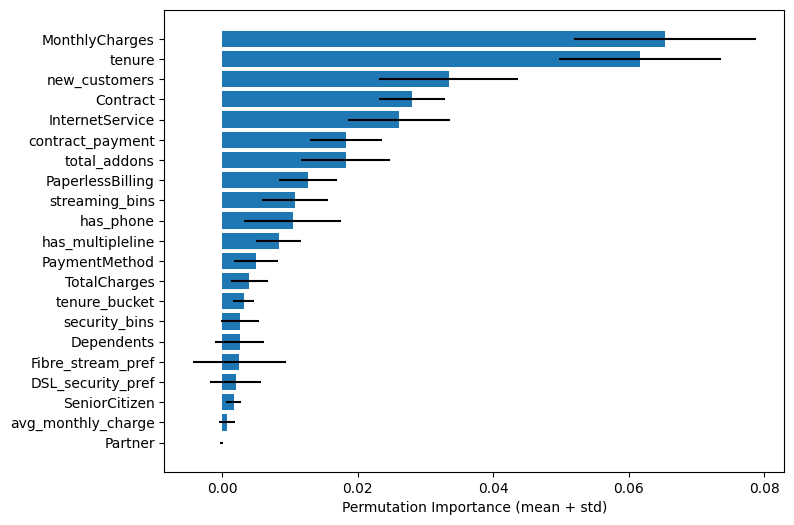

In [ ]:
sorted_idx = imp_sm.importances_mean.argsort()
plt.figure(figsize=(8,6))
plt.barh(np.array(best_estm_sm.feature_names_in_)[sorted_idx],
         imp_sm.importances_mean[sorted_idx],
         xerr=imp_sm.importances_std[sorted_idx]
         )
plt.xlabel("Permutation Importance (mean + std)")
plt.show()

In [ ]:
means = imp_sm.importances_mean
stds = imp_sm.importances_std
n_repeats = 20

se = stds/ np.sqrt(n_repeats)
CI_95 = 1.96 * se

### 95% CI with horizontal bar plot

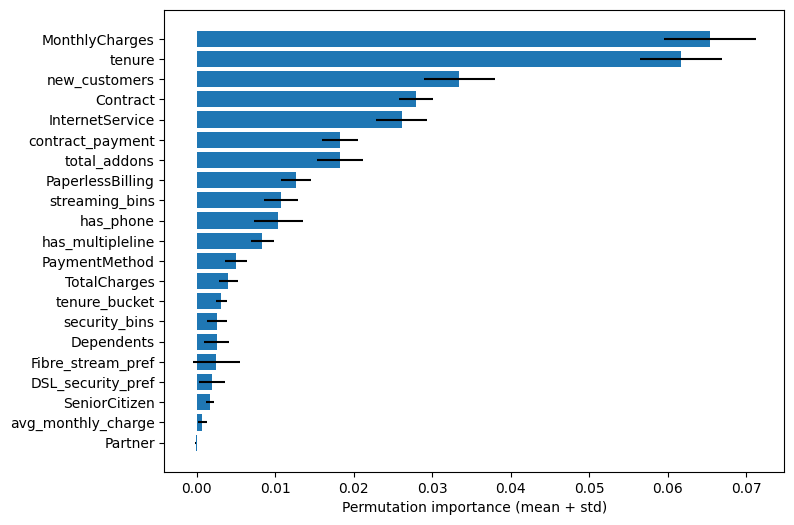

In [ ]:
plt.figure(figsize=(8,6))

sorted_idx = means.argsort()
plt.barh(np.array(best_estm_sm.feature_names_in_)[sorted_idx],
         means[sorted_idx], xerr=CI_95[sorted_idx]
         )
plt.xlabel("Permutation importance (mean + std)")
plt.show()

With SMOTE technique used for balancing the minority class with oversampling. The technique taken beacuse whether the performance are stuck due to imbalance. From the hyperparameter tuning, threshold tuning the performance is still stuck as earlier. So as from this it is clear that the class imbalance is not the main problem. From the Permuatation Importance and Confidence Intervals got the important features for predictions and its intervals of occurrence.

In [ ]:
X = pd.concat([X_tr, X_v, X_ts])
y = pd.concat([y_train, y_val, y_test])

### Permutation Importance on StartifiedKFold

In [ ]:
from tqdm import tqdm

def cv_permute_import(estimator, X, y,
                      cv=5, scoring='average_precision',
                      n_repeats=10, n_jobs=-1,
                      random_state=42):

  skf = StratifiedKFold(n_splits=cv, shuffle=True,
                        random_state=random_state)
  feature_names = X.columns.to_list()
  all_importance = []
  final = []

  for train_idx, val_idx in tqdm(skf.split(X, y), total=cv,
                                 desc='CV folds'):
    X_tr, X_vl = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_vl = y.iloc[train_idx], y.iloc[val_idx]

    estimator.fit(X_tr, y_tr)

    res = permutation_importance(estimator, X_vl, y_vl,
                                 scoring=scoring, n_repeats=n_repeats,
                                 random_state=random_state,
                                 n_jobs=n_jobs)

    all_importance.append(res.importances_mean)
    final.append(res.importances)

  final_res = np.hstack(final)

  arr = np.vstack(all_importance)
  mean_imp = arr.mean(axis=0)
  std_imp = arr.std(axis=0, ddof=1)

  imp_df = pd.DataFrame({
      "Features": feature_names,
      "Importance mean (CV)": mean_imp,
      "Std importance (CV)": std_imp
  }).sort_values('Importance mean (CV)', ascending=False).reset_index(drop=True)

  return imp_df, final_res

In [ ]:
imp_cv, per_res = cv_permute_import(estimator=best_estm_sm, X=X, y=y)

CV folds: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


In [ ]:
imp_cv

,Features,Importance mean (CV),Std importance (CV)
0,tenure,0.065128,0.009886
1,MonthlyCharges,0.054466,0.014788
2,new_customers,0.038967,0.008050
3,InternetService,0.023810,0.011634
4,Contract,0.023454,0.004821
5,total_addons,0.023325,0.007480
6,has_phone,0.014917,0.004202
7,Fibre_stream_pref,0.012315,0.006653
8,contract_payment,0.011736,0.005354
9,PaperlessBilling,0.008960,0.008601


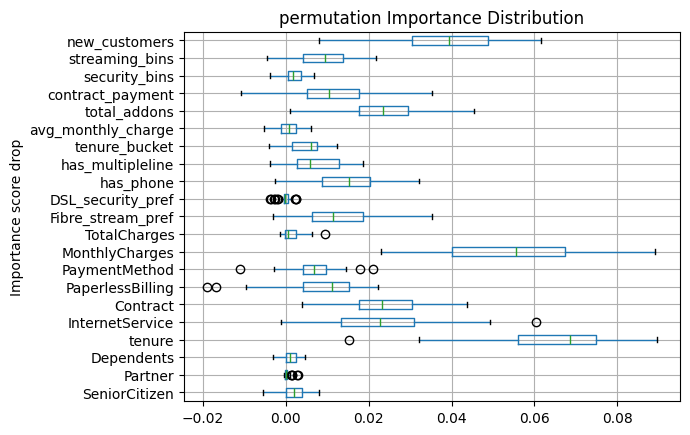

In [ ]:
imp_df = pd.DataFrame(per_res.T, columns=X.columns.to_list())
imp_df.boxplot(vert=False)
plt.ylabel("Importance score drop")
plt.title("permutation Importance Distribution")

plt.show()

### Using SHAP getting per sample direction and interaction

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


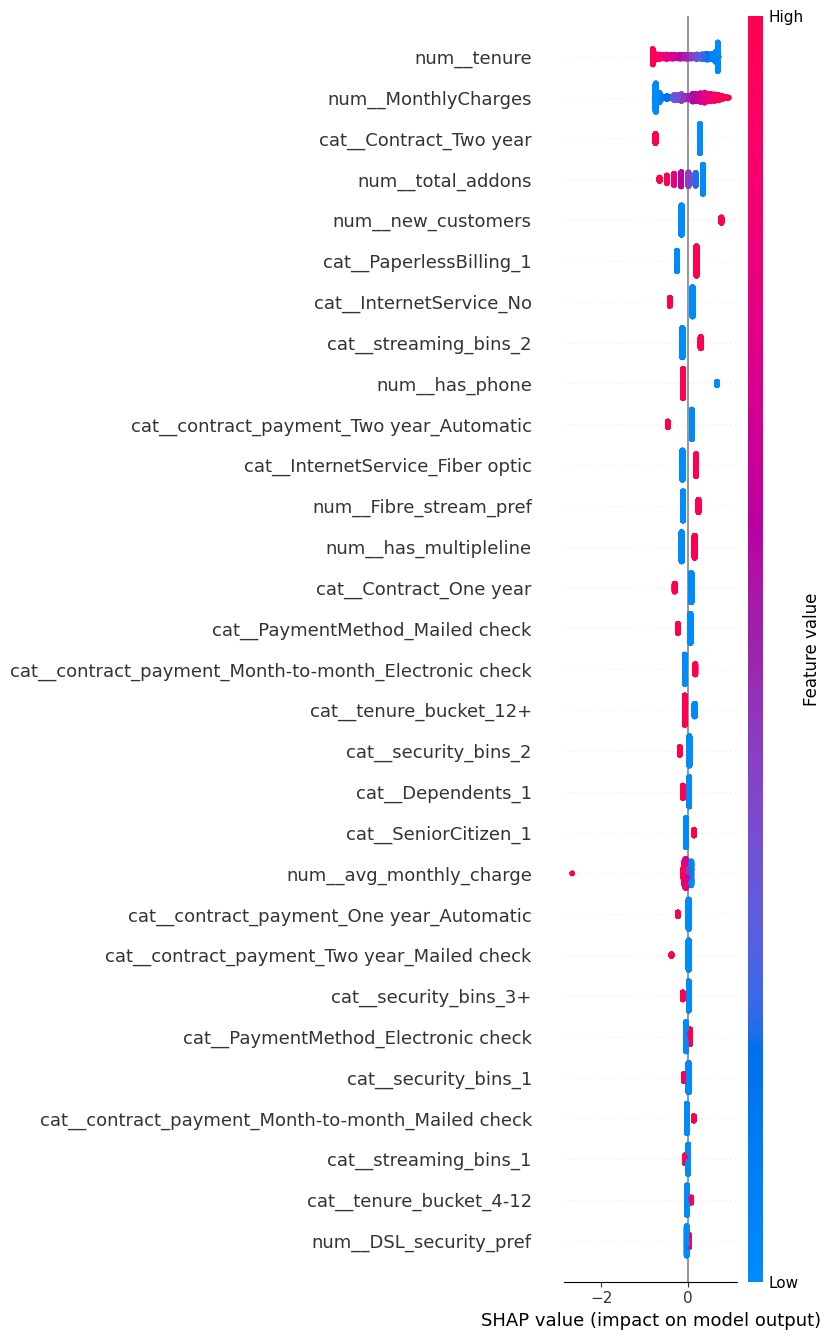

In [ ]:
import shap

pre = best_estm_sm.named_steps['preprocess']
clf = best_estm_sm.named_steps['clf']

X_sample = X_tr.sample(2000, random_state=42)
X_trans = pre.transform(X_sample)

explainer = shap.LinearExplainer(clf, X_trans, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_trans)

shap.summary_plot(shap_values, X_trans, feature_names=pre.get_feature_names_out(), max_display=30)

In [ ]:
shap_df = pd.DataFrame(shap_values, columns=pre.get_feature_names_out())
shap_df.head()

,num__tenure,num__MonthlyCharges,num__TotalCharges,num__Fibre_stream_pref,num__DSL_security_pref,num__has_phone,num__has_multipleline,num__avg_monthly_charge,num__total_addons,num__new_customers,cat__SeniorCitizen_1,cat__Partner_1,cat__Dependents_1,cat__InternetService_Fiber optic,cat__InternetService_No,cat__Contract_One year,cat__Contract_Two year,cat__PaperlessBilling_1,cat__PaymentMethod_Electronic check,cat__PaymentMethod_Mailed check,cat__tenure_bucket_12+,cat__tenure_bucket_4-12,cat__tenure_bucket_Zero,cat__contract_payment_Month-to-month_Electronic check,cat__contract_payment_Month-to-month_Mailed check,cat__contract_payment_One year_Automatic,cat__contract_payment_One year_Electronic check,cat__contract_payment_One year_Mailed check,cat__contract_payment_Two year_Automatic,cat__contract_payment_Two year_Electronic check,cat__contract_payment_Two year_Mailed check,cat__security_bins_1,cat__security_bins_2,cat__security_bins_3+,cat__streaming_bins_1,cat__streaming_bins_2
0,-0.786584,0.918409,0.057071,0.255402,-0.017921,-0.102932,0.166576,-0.107506,-0.649544,-0.138848,-0.037786,0.006845,-0.108239,0.200117,0.116123,0.088717,-0.743869,0.209145,-0.031721,0.067077,-0.061563,-0.011775,-0.0,-0.063236,-0.016347,0.027812,0.004763,0.003211,-0.457839,0.002196,0.028112,0.025905,0.042049,-0.109337,0.015675,0.306865
1,0.107262,-0.743088,-0.017219,-0.104319,-0.017921,-0.102932,-0.136290,0.087513,0.357501,-0.138848,-0.037786,0.006845,0.040033,-0.117529,-0.411710,0.088717,0.289282,-0.245518,-0.031721,-0.224561,-0.061563,-0.011775,-0.0,-0.063236,0.147126,0.027812,0.004763,0.003211,0.100501,0.002196,0.028112,0.025905,0.042049,0.029064,0.015675,-0.119336
2,-0.786584,-0.646369,-0.005291,-0.104319,-0.017921,-0.102932,0.166576,0.075905,0.357501,-0.138848,-0.037786,0.006845,-0.108239,-0.117529,-0.411710,0.088717,-0.743869,-0.245518,-0.031721,0.067077,-0.061563,-0.011775,-0.0,-0.063236,-0.016347,0.027812,0.004763,0.003211,-0.457839,0.002196,0.028112,0.025905,0.042049,0.029064,0.015675,-0.119336
3,0.213672,-0.136866,-0.009761,-0.104319,0.033282,-0.102932,-0.136290,0.014356,0.021819,-0.138848,-0.037786,-0.005163,0.040033,-0.117529,0.116123,0.088717,0.289282,-0.245518,0.058910,0.067077,-0.061563,-0.011775,-0.0,0.179980,-0.016347,0.027812,0.004763,0.003211,0.100501,0.002196,0.028112,0.025905,-0.179261,0.029064,0.015675,-0.119336
4,0.298800,0.145519,-0.009370,-0.104319,-0.017921,-0.102932,-0.136290,-0.012299,0.357501,-0.138848,0.151146,-0.005163,0.040033,0.200117,0.116123,0.088717,0.289282,-0.245518,-0.031721,0.067077,-0.061563,-0.011775,-0.0,-0.063236,-0.016347,0.027812,0.004763,0.003211,0.100501,0.002196,0.028112,0.025905,0.042049,0.029064,0.015675,-0.119336


In [ ]:
def extract_row(col):
  col = col.split('__', 1)[1] if '__' in col else col
  return col.split('_',1)[0]

<Axes: title={'center': 'Mean abs SHAP Per feature'}>

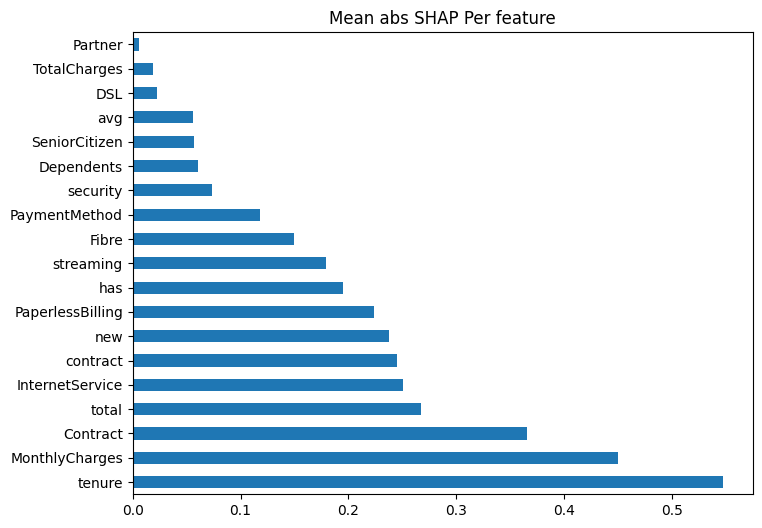

In [ ]:
grouped = shap_df.T.groupby(by=lambda col: extract_row(col)).sum()
mean_shap = grouped.T.abs().mean().sort_values(ascending=False)
mean_shap.plot.barh(figsize=(8,6), title='Mean abs SHAP Per feature')

## SHAP mean estimation with different folds

In [ ]:
import shap

def shap_cv(estimator, X,
            y, clf,
            preprocessor, cv=5,
            ):

  shap_values_list = []
  mean_shap_values = []
  X_trans_all = []

  skf_shap = StratifiedKFold(n_splits=cv, shuffle=True,
                             random_state=42)

  for train_idx, val_idx in tqdm(skf_shap.split(X, y), total=cv,
                                 desc='SHAP CV'):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    estimator.fit(X_train, y_train)

    X_trans = preprocessor.transform(X_val)

    explainer = shap.LinearExplainer(clf, X_trans, feature_perturbation='interventional')
    shap_values = explainer.shap_values(X_trans)
    shap_values_list.append(shap_values)

    X_trans_all.append(X_trans)

  return shap_values_list, X_trans_all


In [ ]:
shap_vals_all, X_trans_all = shap_cv(estimator=best_estm_sm, clf=clf, X=X, y=y,
                             preprocessor=pre)

SHAP CV:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
SHAP CV:  20%|██        | 1/5 [00:01<00:05,  1.29s/it]/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
SHAP CV:  40%|████      | 2/5 [00:02<00:03,  1.03s/it]/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
SHAP CV:  60%|██████    

In [ ]:
all_shap = np.vstack(shap_vals_all)
all_X_trans = np.vstack(X_trans_all)

mean_shap = np.abs(all_shap).mean(axis=0)

mean_df = pd.DataFrame({
    "features": pre.get_feature_names_out(),
    "Mean Absolute SHAP": mean_shap
})

mean_df.sort_values('Mean Absolute SHAP', ascending=False)

,features,Mean Absolute SHAP
0,num__tenure,0.466503
1,num__MonthlyCharges,0.453064
16,cat__Contract_Two year,0.378990
8,num__total_addons,0.269824
9,num__new_customers,0.220611
13,cat__InternetService_Fiber optic,0.183336
14,cat__InternetService_No,0.182340
3,num__Fibre_stream_pref,0.179082
17,cat__PaperlessBilling_1,0.178544
35,cat__streaming_bins_2,0.154782


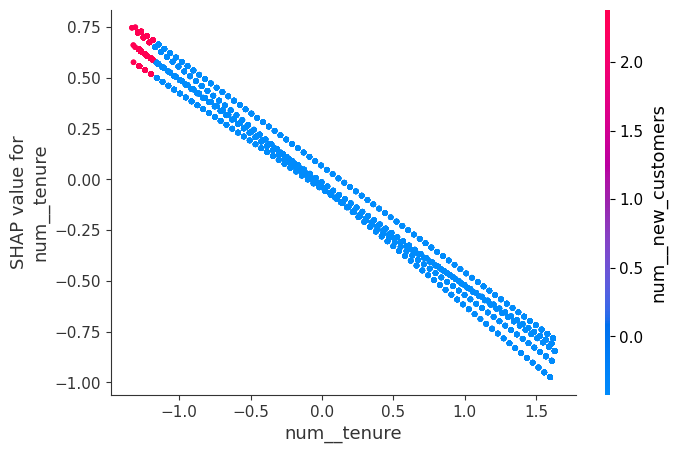

In [ ]:
shap.dependence_plot("num__tenure", all_shap, all_X_trans, feature_names=pre.get_feature_names_out())

In [ ]:
mean_df['Features'] = mean_df['features'].apply(extract_row)

In [ ]:
agg_df = mean_df.groupby('Features')['Mean Absolute SHAP'].sum().sort_values(ascending=False).reset_index()
agg_df

,Features,Mean Absolute SHAP
0,tenure,0.573955
1,Contract,0.501640
2,MonthlyCharges,0.453064
3,contract,0.404063
4,InternetService,0.365676
5,total,0.269824
6,has,0.260565
7,new,0.220611
8,streaming,0.198209
9,Fibre,0.179082


### SHAP plot for whole features

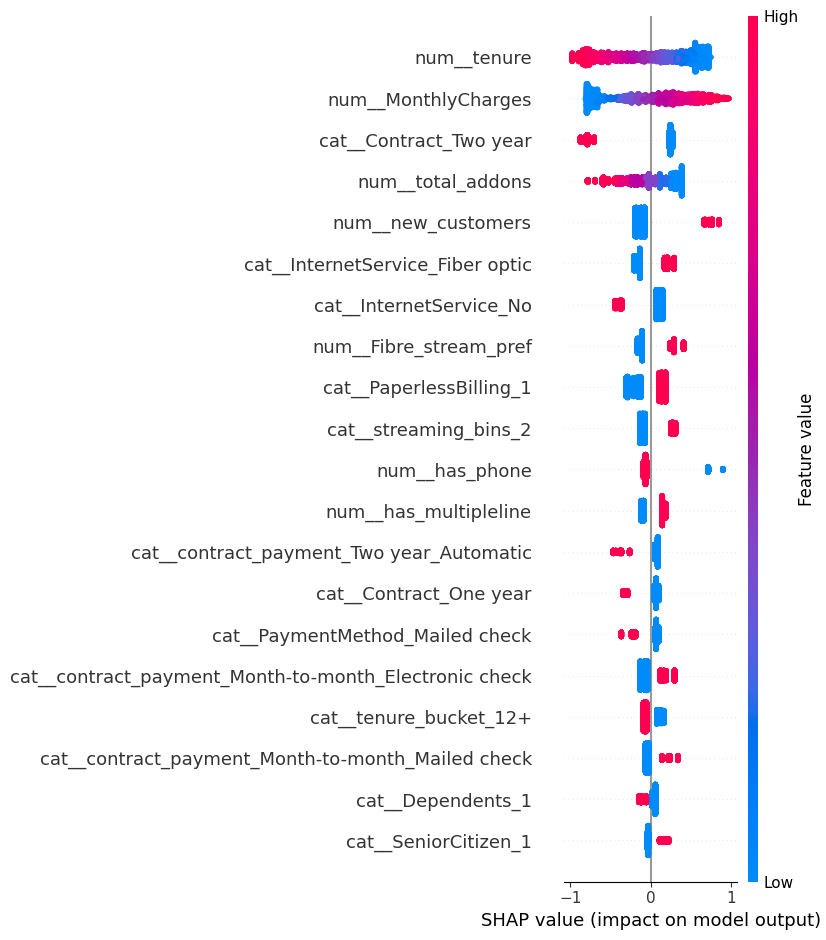

In [ ]:
shap.summary_plot(all_shap, all_X_trans, feature_names=pre.get_feature_names_out())

### Absoute mean for SHAP per feature

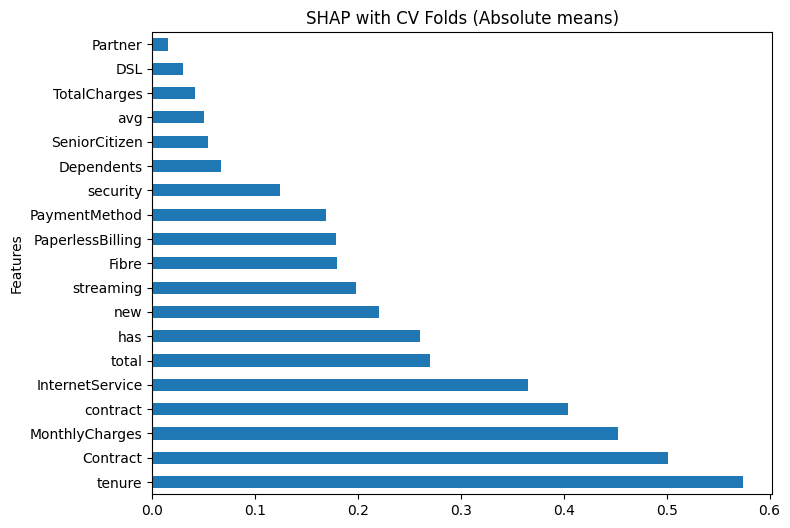

In [ ]:

plt.figure(figsize=(8,6))
agg_df.set_index("Features")['Mean Absolute SHAP'].plot(kind="barh")
plt.title("SHAP with CV Folds (Absolute means)")
plt.show()

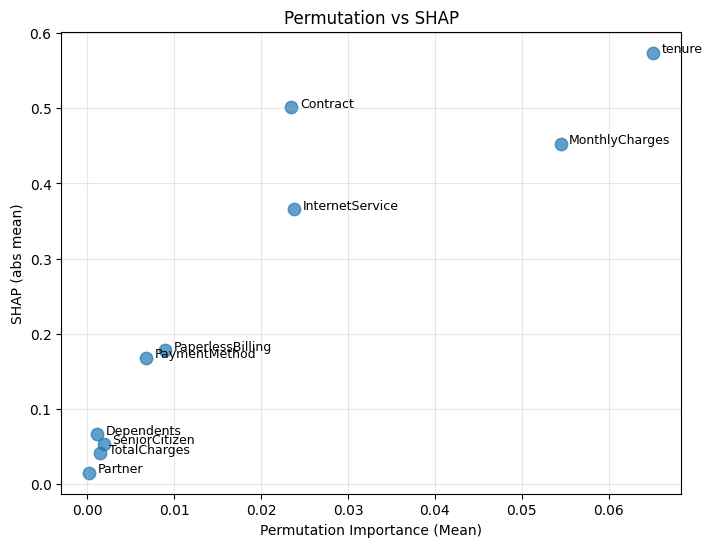

In [ ]:
df = pd.merge(imp_cv, agg_df, on="Features", how="inner")

plt.figure(figsize=(8,6))
plt.scatter(df["Importance mean (CV)"], df["Mean Absolute SHAP"], s=80, alpha=0.7)

for i, row in df.iterrows():
  plt.text(row['Importance mean (CV)']+0.001, row["Mean Absolute SHAP"], row['Features'], fontsize=9)

plt.xlabel("Permutation Importance (Mean)")
plt.ylabel("SHAP (abs mean)")
plt.title("Permutation vs SHAP")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
imp_cv

,Features,Importance mean (CV),Std importance (CV)
0,tenure,0.065128,0.009886
1,MonthlyCharges,0.054466,0.014788
2,new_customers,0.038967,0.008050
3,InternetService,0.023810,0.011634
4,Contract,0.023454,0.004821
5,total_addons,0.023325,0.007480
6,has_phone,0.014917,0.004202
7,Fibre_stream_pref,0.012315,0.006653
8,contract_payment,0.011736,0.005354
9,PaperlessBilling,0.008960,0.008601


From the permuation importance, the important features which will result in churners very more likely. To confirm the importance, run on CV fold check and confirmed the churning features. Founded `tenure`, `Monthly Charges`, `new customers`, `InternetService` has major impact on churn. While `DSL_security_pref`, `Partner`, `avg_monthly_charge` seems very less likely for churn.

From the SHAP, the importance of features for predictions is determined through its direction too. When taking the importance for per feature using SHAP with mean absolute the tenure seems more important. When checking the SHAP summary plot the whole  features to the model with direction to churn and no-churn is identified.

Inference: tenure with long subscriptions has churn less than with small subscriptions and high monthly charges group churn more considered the main predictors for churn and dependents, seniorcitizen seems less predictors.

In [ ]:
from imblearn.pipeline import Pipeline as pipe

X_copy = X

In [ ]:
X_copy = X_copy.drop(columns=['DSL_security_pref', 'Partner'], axis=1)
X_copy.head()

,SeniorCitizen,Dependents,tenure,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Fibre_stream_pref,has_phone,has_multipleline,tenure_bucket,avg_monthly_charge,total_addons,contract_payment,security_bins,streaming_bins,new_customers
2312,0,0,18.0,No,One year,0,Mailed check,20.10,401.85,0,1,0,12+,22.325000,0,One year_Mailed check,0,0,0
5227,0,0,7.0,Fiber optic,Month-to-month,0,Electronic check,96.20,639.70,1,1,1,4-12,91.385714,2,Month-to-month_Electronic check,0,2,0
6404,0,0,52.0,Fiber optic,Two year,1,Electronic check,109.30,5731.40,1,1,1,12+,110.219231,5,Two year_Electronic check,3+,2,0
88,0,1,46.0,No,Two year,1,Mailed check,19.95,927.10,0,1,0,12+,20.154348,0,Two year_Mailed check,0,0,0
6496,1,0,40.0,Fiber optic,Month-to-month,0,Electronic check,101.85,4086.30,1,1,1,12+,102.157500,3,Month-to-month_Electronic check,1,2,0


In [ ]:
val_ratio = 0.15 / (1-0.15)

X_temp_cop, X_test_cop, y_temp_cop, y_test_cop = train_test_split(X_copy, y,
                                                                  test_size=0.15,
                                                                  stratify=y, random_state=42)

X_tr_cop, X_val_cop, y_tr_cop, y_val_cop = train_test_split(X_temp_cop, y_temp_cop,
                                                            test_size=val_ratio,
                                                            stratify=y_temp_cop,
                                                            random_state=42)

X_tr_cop.shape, X_val_cop.shape, X_test_cop.shape, y_tr_cop.shape, y_val_cop.shape, y_test_cop.shape

((4929, 19), (1057, 19), (1057, 19), (4929,), (1057,), (1057,))

In [ ]:
num_cols = X_tr_cop.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_tr_cop.select_dtypes(include=['category', 'object']).columns.tolist()

In [ ]:
pre = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
], remainder='drop')


smote = SMOTE(random_state=42)
clf = LogisticRegression(solver='saga', penalty='l2',
                         max_iter=1000, random_state=42,
                         class_weight='balanced')
clf

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='saga')

In [ ]:
pipeline_lr = pipe([
    ('prepr', pre),
    ('smote', smote),
    ('clf', clf)
])

In [ ]:
param_grid = {
    'smote__k_neighbors': [3,5, 7],
    'smote__sampling_strategy': [0.5, 0.75, 1.0],
    'clf__C': [0.01, 0.1, 1.0],
    'clf__penalty': ['l2']
}

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_sm_lr = GridSearchCV(pipeline_lr, param_grid=param_grid,
                          cv=cv, scoring='average_precision',
                          n_jobs=-1)

grid_sm_lr.fit(X_tr_cop, y_tr_cop)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prepr',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'Fibre_stream_pref',
                                                                          'has_phone',
                                                                          'has_multipleline',
                                                                          'avg_monthly_charge',
                                                                          'total_addons',
                                                                          'new_customers']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handl...
                                                                          'contract_payment',
                                                                          'security_bins',
                                                                          'streaming_bins'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1.0], 'clf__penalty': ['l2'],
                         'smote__k_neighbors': [3, 5, 7],
                         'smote__sampling_strategy': [0.5, 0.75, 1.0]},
             scoring='average_precision')

In [ ]:
best_estm_smlr = grid_sm_lr.best_estimator_

print("Best Score for the estimator:", grid_sm_lr.best_score_)
print("Best params for the estimator:", grid_sm_lr.best_score_)

Best Score for the estimator: 0.6668324662358657
Best params for the estimator: 0.6668324662358657


In [ ]:
y_val_pred_sm_lr = best_estm_smlr.predict(X_val_cop)
y_val_prob_smlr = best_estm_smlr.predict_proba(X_val_cop)[:, 1]

print("Classification Report:\n\n", classification_report(y_val_cop, y_val_pred_sm_lr))
print("Average precision:", average_precision_score(y_val_cop, y_val_prob_smlr))
print("ROC_AUC:", roc_auc_score(y_val_cop, y_val_prob_smlr))

Classification Report:

               precision    recall  f1-score   support

           0       0.90      0.73      0.81       776
           1       0.51      0.79      0.62       281

    accuracy                           0.74      1057
   macro avg       0.71      0.76      0.71      1057
weighted avg       0.80      0.74      0.76      1057

Average precision: 0.6583416894025894
ROC_AUC: 0.8411577759841509


From the different techniques, it is noted that the performance is stuck at a point. Especially `f1 score` is stuck at 0.63 for every technique. With use of SMOTE for minority class to ignore problem of class imbalance didn't worked as expected. With the PR cuve and threshold tuning there was an improvement in performance but every time stuck at a point. from permutation importance the important features were clear and SHAP shows the features direction with the churn or not. 

The major problem may be because as the features  contains categorical and Logistic Regression may not able to catch the relationship between the features. The Tree models will be a good choice for the solution.